<div style="padding:2%;background-color: silver;height: 100px; color: white; border-radius: 5px;">
    <h1>Just enough Data Science and Machine Learning</h1>
    <h2>Essential tools and techniques</h2>
</div>

# Chapter 4 - Machine Learning Tool

## Install Python libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip3 install numpy pandas scikit-learn scipy seaborn keras gensim torch
!pip install folium

## Import libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import string
from time import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, silhouette_samples, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_20newsgroups

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import LabelPropagation

from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.hierarchy import dendrogram

from keras.models import Sequential
from keras.layers import Dense

import gensim
import gensim.corpora as corpora
from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import CoherenceModel

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D

import colorsys
import folium

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mgikh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Plot settings

In [3]:
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 14),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

xxlarge = 16
xlarge = 16
large = 12

plt.rcParams.update(params)
plt.rcParams['font.size'] = '26'

# Plot style
sns.set()
sns.set_style("white")

## Helper functions

In [4]:
def getEvaluationReport(expected_y, predicted_y):
    f1_report = classification_report(expected_y, predicted_y, target_names=['0','1'])
    micro_f1 = precision_recall_fscore_support(expected_y, predicted_y, average='micro')
    macro_f1 = precision_recall_fscore_support(expected_y, predicted_y, average='macro')
    print(f1_report)
    print("micro avg", micro_f1[0], micro_f1[1])
    
def getConfusionMatrix(test_y, pred_y):
    # plotting graph for confusion matrix
    cm = confusion_matrix(test_y, pred_y)
    
    plt.figure(figsize=(5,5))
    
    sns.heatmap(cm, annot=True, cbar=False, linewidths=2, xticklabels = ['Negative (0)','Positive (1)'], yticklabels = ['Negative (0)','Positive (1)'], square=True, fmt="d")
    
    plt.title('confusion matrix')
    plt.xlabel('Predictive values', fontsize=16)
    plt.ylabel('Actual values', fontsize=16);

# Calculate euclidean distance between two points 
def  getDistance(point1, point2): 
    euc_dist = 0
    for i in range(len(point1)):
        euc_dist = euc_dist + (point1[i] - point2[i]) ** 2
    return euc_dist ** 0.5 

# Calcualte Dunn Index
def calcDunnIndex(data, cluster):
    data = np.array(data)
    m, n = data.shape
    points = data.reshape(m * n, 1)
    numerator = float('inf')
    for c in cluster: 
        for t in cluster:
            if (t == c).all(): continue # if it is the same cluster, we skip it
            n_dis = getDistance(t, c)
            numerator = min(numerator, n_dis) # find distance between centroids of each cluster
    denominator = 0
    for c in cluster: # for each cluster
        for p in points: # for each point
            for t in points: # for each point
                if (t == p).all(): continue # if we compare the same point, then we skip it
                d_dist = getDistance(t, p) # find the distance
                denominator = max(denominator, d_dist)
    return numerator/denominator


## 4.2 Evaluation
<div class="alert alert-info" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"/>
        </div>
        <div class="col-xs-11">
            <strong>The evaluation results and values in the confusion matrix may vary from those in the book due to randomisation of the data or where the notion of randomness is an inherent component of the algoritm itself.</strong>
        </div>
    </div>
</div>

**Example 4.1**: A real example of a confusion matrix evaluating the results of using logistic regression to identify individuals likely to develop diabetes, is shown in Figure 4.2. The data employed for the logistic regression was curated by the National Institute of Diabetes and Digestive and Kidney Diseases; see Table 4.1 for a sample from the data set. The full data set is composed of 768 rows recording the number of pregnancies patients had, their plasma glucose concentration, blood pressure (bp), skin fold thickness, insulin levels, BMI (bmi), age and outcome (label), among women in the Pima Indian society. We note that the data set is composed of female participants with an average age of 33 years. The precision, recall and F1 for the logistic regression model are shown in stylised form in Table 4.2.

### 4.2.1 Evaluation for Supervised Models

In [5]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

# load dataset
pima = pd.read_csv("./data/pimaindians.csv")
pima.columns = col_names

print(pima.head())

# split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = pima[feature_cols] # Features
y = pima.label # Target variable

# split X and Y into training and testing sets, X is the data used to train, and Y holds the known label we want to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# instantiate the model (using the default parameters)
model = LogisticRegression(max_iter=200)

# fit the model with data
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)



   pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
0         6      148  72    35        0  33.6     0.627   50      1
1         1       85  66    29        0  26.6     0.351   31      0
2         8      183  64     0        0  23.3     0.672   32      1
3         1       89  66    23       94  28.1     0.167   21      0
4         0      137  40    35      168  43.1     2.288   33      1


Table 4.1: A sample from the Pima Indian Diabetes data set, where a class label with a value of 0 indicates that the individual does not have diabetes, while a value of 1 indicates that the individual has diabetes.

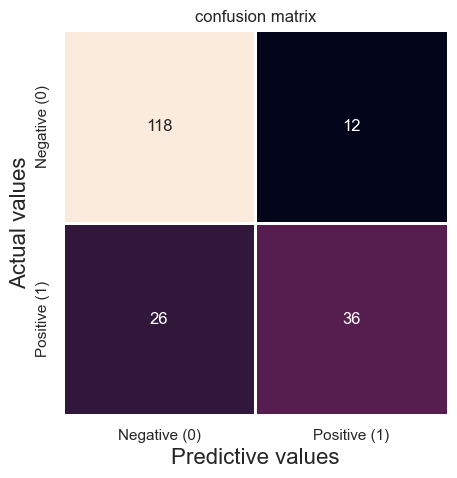

In [6]:
getConfusionMatrix(y_test, y_pred)

Figure 4.2: The confusion matrix describing the model performance of a logistic regression model trained on the Pima Indian Diabetes data set.

In [7]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       130
           1       0.75      0.58      0.65        62

    accuracy                           0.80       192
   macro avg       0.78      0.74      0.76       192
weighted avg       0.80      0.80      0.79       192

micro avg 0.8020833333333334 0.8020833333333334


Table 4.2: The precision, recall, and F1 of the logistic regression model applied to the Pima Indian Diabetes data set with a 75-25 split between the training and test data.

### 4.2.1 Evaluation for Unsupervised Models
**Example 4.2**: An elbow plot depicting the number of clusters along the x-axis and the SSE on the y-axis is shown in Figure 4.3. In particular, such an elbow plot allows us to compare the SSE against the number of clusters in order to find the point after which the SSE drops and the curve bends; see Subsection 4.4.1 for more detailed motivation of the elbow heuristic in the context of k-means, where the number of desired clusters k is an input parameter to the algorithm. The elbow plot was generated from the Iris data set by applying the k-means clustering algorithm (see Subsection 4.4.1) to label each row of the data with a cluster value based on the width and length of the petals of the Iris in centimetres; see Table 4.3 for a sample from the data set. The elbow plot in Figure 4.3 suggests that k = 2 is most likely (and this is indeed the case, as the data set we used was generated from two species of flower, the Iris setosa and the Iris versicolour), although from the plot one may argue that k = 3 is also reasonable.

In [8]:
iris = load_iris()

X = pd.DataFrame(iris.data, columns=iris['feature_names'])

data = X[['petal width (cm)', 'petal length (cm)']]
print(data[:5])

sse = {}
K = 10

for k in range(1, K):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

   petal width (cm)  petal length (cm)
0               0.2                1.4
1               0.2                1.4
2               0.2                1.3
3               0.2                1.5
4               0.2                1.4


Table 4.3: A sample from the Iris data set, for two species, extracting two features representing the petal width and petal length of Iris flowers, both in centimetres (cm).

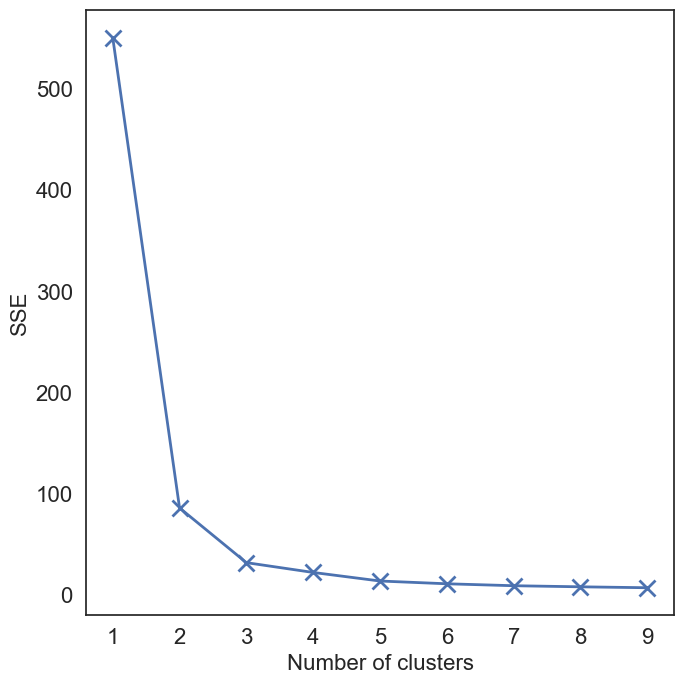

In [9]:
plt.figure(figsize=(7, 7))
plt.plot(list(sse.keys()), list(sse.values()), '-x', markersize=12, markeredgewidth=2, linewidth=2)

plt.xlabel("Number of clusters", size=xxlarge)
plt.ylabel("SSE", size=xxlarge)
plt.grid(False)

plt.xticks(fontsize=xlarge)
plt.yticks(fontsize=xlarge)

plt.tight_layout()

Figure 4.3: An elbow plot for the Iris data set, with the number of clusters along the x-axis and the SSE on the y-axis. 

**Example 4.3**: The Dunn index and silhoutee coefficient values based on the clusters output by the k-means algorithm, for k = 2 to k = 6, operating on the Iris data set introduced above, are shown in Table 4.4; the corresponding silhouette plot is shown in Figure 4.4.

In [10]:
# load Iris data
data = load_iris()

# load into Dataframe 
df = pd.DataFrame(data.data,columns = data.feature_names)
df = df.drop(['sepal length (cm)', 'sepal width (cm)'],axis = 'columns')
print(df.head())

# Calculate the silhouette coefficient
scores = []
K = 6

   petal length (cm)  petal width (cm)
0                1.4               0.2
1                1.4               0.2
2                1.3               0.2
3                1.5               0.2
4                1.4               0.2


Table 4.3: A sample from the Iris data set, for two species, extracting two features representing the petal width and petal length of Iris flowers, both in centimetres (cm).

In [11]:
print("k", "Dunn index", "Silhouette Coefficient")
for k in range(2, K+1):
    # Run the kmeans algorithm
    km = KMeans(n_clusters= k)
    y_predict = km.fit_predict(df)
    centroids  = km.cluster_centers_
    
    dunn_idx = calcDunnIndex(df, centroids)
    
    sil_score = silhouette_score(df, km.labels_, metric='euclidean')

    scores.append([k, dunn_idx, sil_score])
    print(k, dunn_idx, sil_score)

df_scores = pd.DataFrame(scores, columns=['k', 'dunn', 'silhouette score'])


silhouette_vals = silhouette_samples(df, y_predict)

k Dunn index Silhouette Coefficient
2 0.5462975855813065 0.7653904101258123
3 0.22025301527723118 0.6604800083974887
4 0.14116382535606167 0.6128714659599253
5 0.12964460769767563 0.5883732712110276
6 0.09947465887741046 0.5751269337322084


Table 4.4: A summary of the Dunn index and silhouette coefficients (i.e. the overall average silhouette width) for the clusters output by k-means, with k = 2 to k = 6, computed over the Iris data set.

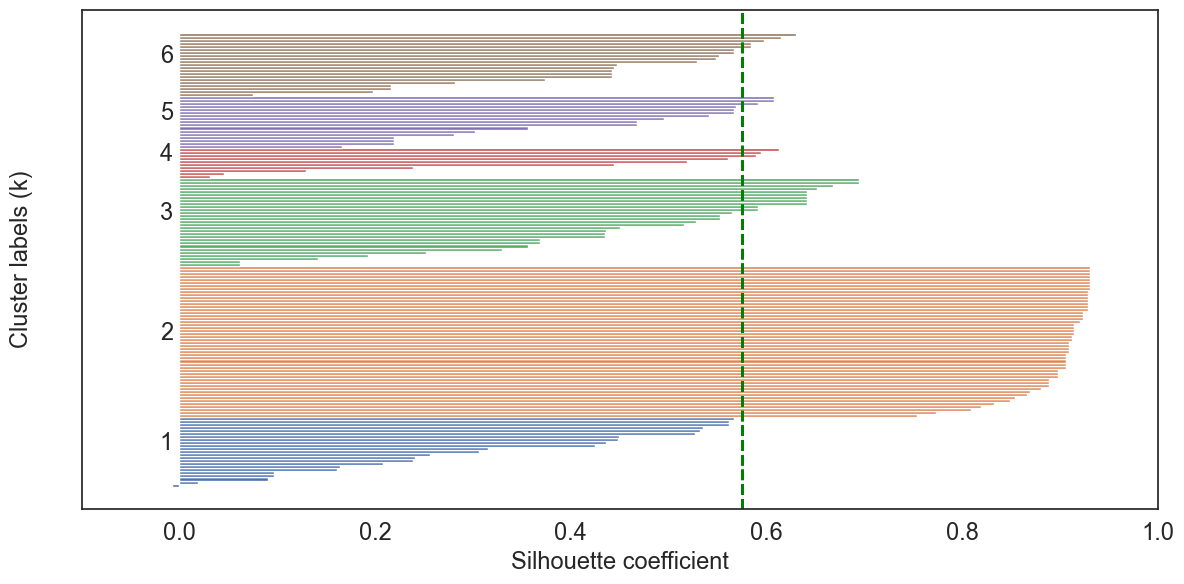

In [12]:
# Create silhouette plot
fig, ax = plt.subplots(1 , 1, figsize=(12, 6))

y_ticks = []
y_lower = 0
y_upper = 0

for i, cluster in enumerate(np.unique(y_predict)):
    cluster_silhouette_vals = silhouette_vals[y_predict == cluster]
    cluster_silhouette_vals.sort()
    
    y_upper += len(cluster_silhouette_vals)
   
    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1);

    # Add a label
    ax.text(-0.02, (y_lower + y_upper) / 2, str(i + 1), fontsize=17)
    y_lower += len(cluster_silhouette_vals)
       
    # Get the average silhouette score 
    avg_score = np.mean(silhouette_vals)
    
    ax.axvline(avg_score, linestyle ='--', linewidth=2, color = 'green')
    ax.set_yticks([])

    
ax.set_facecolor('white')
ax.set_xlabel('Silhouette coefficient',fontsize=17)
ax.set_ylabel('Cluster labels (k)',fontsize=17, labelpad=35)
ax.set_xlim([-.1, 1])

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()

Figure 4.4: The silhouette plot for k = 6 clusters generated by k-means computed over the Iris data set. The vertical line represents the silhouette coefficient, which is 0.571 in this case (see Table 4.4).

## 4.3 Supervised Methods

### 4.3.1 K-Nearest Neighbours
**Example 4.4**: An exoplant is a planet that orbits a star outside the solar system; data on expolanets is available for download from the NASA Exoplanet Archive. The data set describes the characterisation of exoplanet and their host stars. An exoplanet (also known as an extrasolar planet) is a planet outside the solar system. The data includes exoplanet parameters including masses and orbital parameters and characterisation data, including radial velocity curves, photometric light curves, images, and spectral analyses; see Table 4.5 or a sample from the data set, where planets which are considered extrasolar re labelled by a 1 and those which are not by a 0. he confusion matrix is shown in Figure 4.5 and the precision, recall and 1 for the KNN model are shown in stylised form in Table 4.6.

In [13]:
df = pd.read_csv('./data/exoplanets_2018.csv')
df.fillna(0.0, inplace=True)

fields = ['stellar radius', 'right ascension', 'declination', 'Kepler-band', 'label']

print(df[fields].head())

k = 5

Y = df['label']
X = df.drop(columns='label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

   stellar radius  right ascension  declination  Kepler-band  label
0           0.927        291.93423    48.141651       15.347      1
1           0.927        291.93423    48.141651       15.347      1
2           0.868        297.00482    48.134129       15.436      0
3           0.791        285.53461    48.285210       15.597      0
4           1.046        288.75488    48.226200       15.509      1


Table 4.5: A sample from the exoplanet data set recording attributes of the candidate exoplanets, where the label column records a 1 for exoplanets and a 0 otherwise.

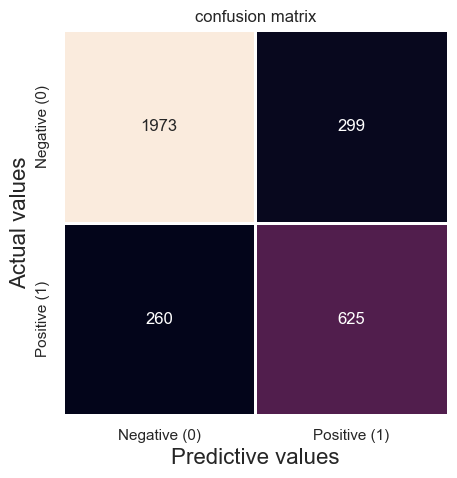

In [14]:
getConfusionMatrix(y_test, y_pred)

Figure 4.5: The confusion matrix describing the model performance of a KNN model computed on the exoplanet data set. 

In [15]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2272
           1       0.68      0.71      0.69       885

    accuracy                           0.82      3157
   macro avg       0.78      0.79      0.78      3157
weighted avg       0.83      0.82      0.82      3157

micro avg 0.822933164396579 0.822933164396579


Table 4.6: The precision, recall, and F1 for a KNN model applied to the exoplanet data set with a 67-33 split between the training and test data.

**Example 4.5**: In Table 4.7 we show a sample from an SMS (short message service) data set that has been collected for SMS spam research containing SMS messages in English labelled according to whether they are ham (legitimate email) or spam (junk mail). We first apply Bernoulli naive Bayes to categorise the SMS messages into one of two classes: spam or ham; the confusion matrix summarising the performance of trained model is shown in Figure 4.6. The precision, recall and F1 for the Bernoulli naive Bayes model are shown in stylised form in Table 4.8. Second we apply multinomial naive Bayes to categorise the SMS messages; the confusion matrix summarising the performance of trained model is shown in Figure 4.7. The precision, recall and F1 for the multinomial naive Bayes model are shown in stylised form in Table 4.9. In Table 4.10 we show a sample from a data set recording 23 species of gilled mushrooms in the Agaricus and Lepiota family. Each species is identified as being either edible (labelled as 1), or as being definitely poisonous or of unknown edibility and not recommended (labelled as 0). Third we apply the Gaussian naive Bayes to categorise the mushrooms; the confusion matrix summarising the performance of trained model is shown in Figure 4.8. The precision, recall and F1 for the Gaussian naive Bayes model are shown in stylised form in Table 4.11.

In [16]:
data = pd.read_csv('./data/SMSSpamCollection.txt', delimiter="\t", names=["label", "text"])
data = data.replace(['ham','spam'],[0, 1])

print(data.head(5))


text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

#features are the word_vectors
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data['text'])
features.shape

#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

# initialise multiple classification models
mnb1 = MultinomialNB()
mnb2 = BernoulliNB()

#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

X = X_train.toarray()
y = y_train.to_numpy()
z = X_test.toarray()

a = mnb1.fit(X, y)
b = mnb2.fit(X, y)

# predict class probabilities for all classifiers
probas = a.predict_proba(z)

# get class probabilities for the first sample in the dataset
class1_1 = [pr for pr in probas]

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


Table 4.7: A sample from the spam or ham SMS messages data set, where the label column records a 0 for ham messages an a 1 for spam messages.

In [17]:
# Bernoulli Naive Bayes
y_pred = mnb2.predict(z)
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       729
           1       1.00      0.87      0.93       107

    accuracy                           0.98       836
   macro avg       0.99      0.93      0.96       836
weighted avg       0.98      0.98      0.98       836

micro avg 0.9832535885167464 0.9832535885167464


Table 4.8: The precision, recall, and F1-score for a Bernoulli naive Bayes classifier with a 85-15 split between the training and test data, and used to classify email messages into ham (labelled as 0), or spam (labelled 1) using a training set of examples.

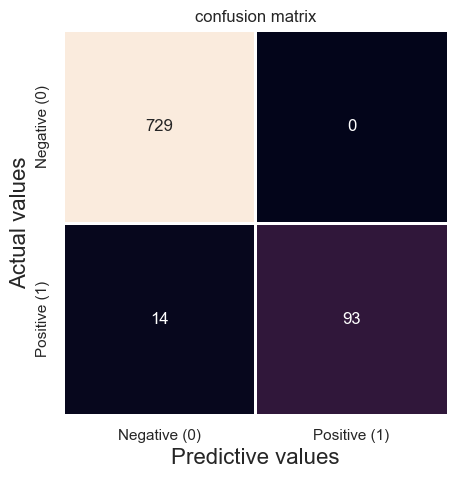

In [18]:
getConfusionMatrix(y_test, y_pred)

Figure 4.6: The confusion matrix for the Bernoulli naive Bayes model trained on the SMS data set.

In [19]:
# Multinomial Naive Bayes
y_pred = mnb1.predict(z)
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       729
           1       1.00      0.73      0.84       107

    accuracy                           0.97       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.97      0.97      0.96       836

micro avg 0.965311004784689 0.965311004784689


Table 4.9: The precision, recall, and F1-score for a Multinomial naive Bayes classifier with a 85-15 split between the training and test data, and used to classify email messages into ham (labelled as 0), or spam (labelled 1) using a training set of examples.

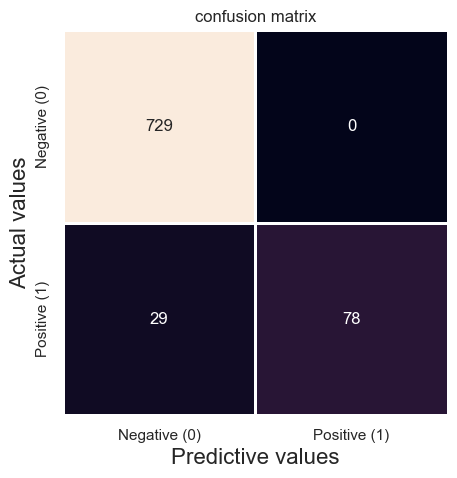

In [20]:
getConfusionMatrix(y_test, y_pred)

Figure 4.7: The confusion matrix for the Multinomial naive Bayes model trained on the SMS data set.

In [21]:
# Gaussian Naive Bayes
df = pd.read_csv('./data/agaricus-lepiota.data.csv')

fields = ['target',
'cap-shape',
'cap-color',
'bruises',
'odor',
'gill-spacing',
'gill-size']

print(df[fields].head())


LE = LabelEncoder()
for c in df.columns:
    prev = c
    df[c] = LE.fit_transform(df[c])
    if c == 'target':
        print(prev, c, df[c])

print(df[fields].head())

y = df['target']
X = df.drop('target', axis='columns')

model = GaussianNB()
model.fit(X, y)

  target cap-shape cap-color bruises odor gill-spacing gill-size
0      p         x         n       t    p            c         n
1      e         x         y       t    a            c         b
2      e         b         w       t    l            c         b
3      p         x         w       t    p            c         n
4      e         x         g       f    n            w         b
target target 0       1
1       0
2       0
3       1
4       0
       ..
8119    0
8120    0
8121    0
8122    1
8123    0
Name: target, Length: 8124, dtype: int32
   target  cap-shape  cap-color  bruises  odor  gill-spacing  gill-size
0       1          5          4        1     6             0          1
1       0          5          9        1     0             0          0
2       0          0          8        1     3             0          0
3       1          5          8        1     6             0          1
4       0          5          3        0     5             1          0


GaussianNB()

Table 4.10: A sample from the mushroom data set recording various physical attributes of mushrooms, with a target label where a 0 means it is safe to consume, and a 1 means the mushroom is poisonous.

In [22]:
y_pred = mnb1.predict(z)
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       729
           1       1.00      0.73      0.84       107

    accuracy                           0.97       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.97      0.97      0.96       836

micro avg 0.965311004784689 0.965311004784689


Table 4.11: The precision, recall, and F1-score for a Gaussian naive Bayes classifier with a 85-15 split between the training and test data, and used to classify mushrooms as safe (labelled as 0), or poisonous (labelled 1) using a training set of examples.

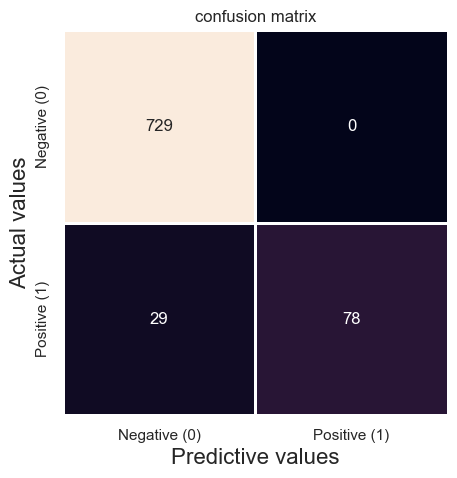

In [23]:
getConfusionMatrix(y_test, y_pred)

Figure 4.8: The confusion matrix for the Gaussian naive Bayes model trained on the mushroom data set.

### 4.3.3 Support Vector Machines

**Example 4.6**: A sample from the Iris data for two species, Iris setosa and Iris versicolor, is shown in Table 4.3, and a scatter plot exhibiting the hard margin between the two classes is shown Figure 4.11. To demonstrate soft margin classification, we used an alternative data set for the two species, Iris versicolor and Iris virginica. A scatter plot exhibiting the soft margin between these two classes is shown Figure 4.12. The confusion matrix summarising the performance of the hard margin SVM classifier trained on the Iris setosa and versicolor data set, is shown in Figure 4.13, and the precision, recall and F1 for the hard SVM classifier are shown in stylised form in Table 4.12. Correspondingly, the confusion matrix for the soft margin SVM classifier trained on the Iris versisolor and virginica data set is shown in Figure 4.14, and the and the precision, recall and F1 for the soft margin SVN classifier are shown in stylised form in Table 4.13.

In [24]:
iris = load_iris()

X = pd.DataFrame(iris.data, columns=iris['feature_names'])

data = X[['petal width (cm)', 'petal length (cm)']]
print(data[:5])

   petal width (cm)  petal length (cm)
0               0.2                1.4
1               0.2                1.4
2               0.2                1.3
3               0.2                1.5
4               0.2                1.4


Table 4.3: A sample from the Iris data set, for two species, extracting two features representing the petal width and petal length of Iris flowers, both in centimetres (cm).

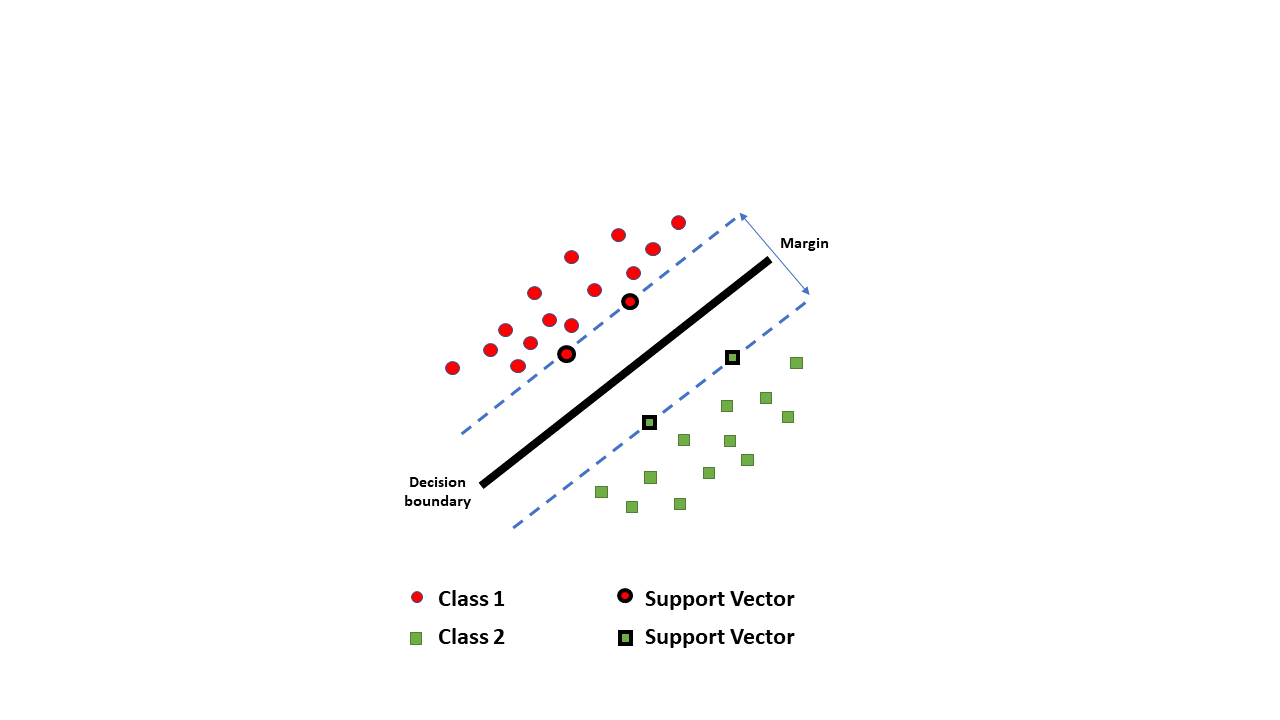

Figure 4.9: Example of an SVM hard margin.

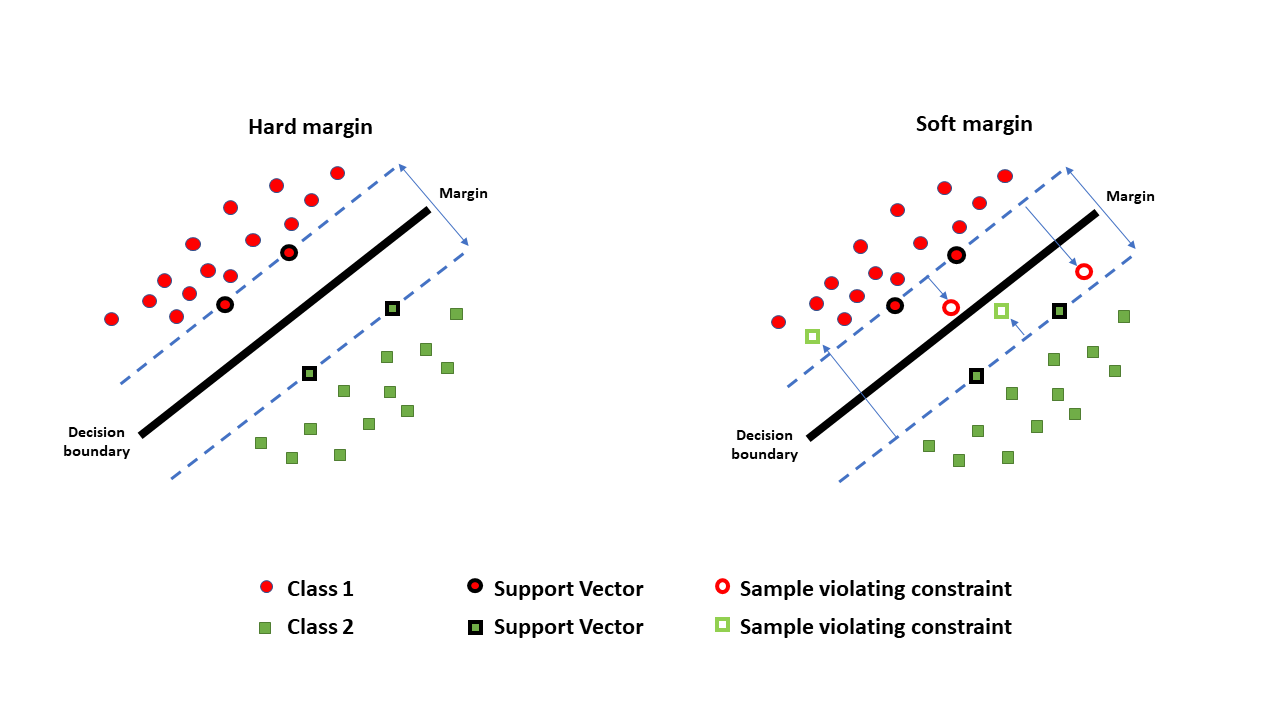

Figure 4.10: Example of SVM hard and soft margin

In [25]:
dataset = pd.read_csv(r'./data/iris.data', header=None)

X = dataset.iloc[:,[2,3]].values
Y = dataset.iloc[:, 4].values

Y[Y == 'Iris-versicolor'] = 0
Y[Y == 'Iris-setosa'] = 1
Y = Y.astype('int')

#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=111)

# fit the model
name, penalty = ("hard", 2)

model = svm.SVC(kernel="linear", C=penalty)

model.fit(X_train, y_train)

y_test_hard = y_test
y_pred_hard = model.predict(X_test)

In [26]:
getEvaluationReport(y_test_hard, y_pred_hard)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        14

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

micro avg 1.0 1.0


Table 4.12: The precision, recall, and F1-score for a hard margin SVM binary classifier trained on the Iris data with classes Iris versicolor (class 0) and Iris setosa (class 1).  We use a 67-33 split between the training and test data for evaluation.

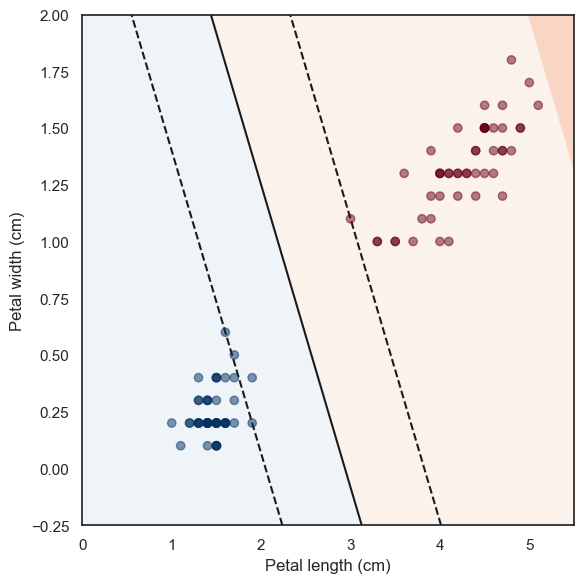

In [27]:
x_min = 0
x_max = 5.5
y_min = -0.25
y_max = 2


# get the separating hyperplane
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 8)
yy = a * xx - (model.intercept_[0]) / w[1]

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)


margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(6, 6))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

plt.scatter( X[:, 0], X[:, 1], c=Y, zorder=10,  cmap=cm.get_cmap("RdBu"), alpha=0.5)

plt.axis("tight")

# Put the result into a contour plot
plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")

# Add a legend.
plt.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    cmap=cm.get_cmap("RdBu"),
)

plt.tight_layout()

Figure 4.11: A scatter plot of the Iris data set for the two classes representing the species Iris setosa and Iris versicolor. The decision boundary was computed using hard margin SVM classification, and shows the hard margin between the two classes.

In [28]:
dataset = pd.read_csv(r'./data/iris_1b.txt', header=None)

X = dataset.iloc[:,[2,3]].values
Y = dataset.iloc[:, 4].values

Y[Y == 'Iris-versicolor'] = 0
Y[Y == 'Iris-virginica'] = 1
Y = Y.astype('int')

# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=111)

# fit the model
name, penalty = ("soft", 100)

model = svm.SVC(kernel="linear", C=penalty)

model.fit(X_train, y_train)

y_test_soft = y_test
y_pred_soft = model.predict(X_test)

In [29]:
getEvaluationReport(y_test_soft, y_pred_soft)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.95      0.95      0.95        19

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33

micro avg 0.9393939393939394 0.9393939393939394


Table 4.13: The precision, recall, and F1-score for a soft margin SVM binary classifier, with C = 100, trained on the Iris data with classes Iris versicolor (class 0) and Iris virginica (class 1). We use a 67-33 split between the training and test data for evaluation.

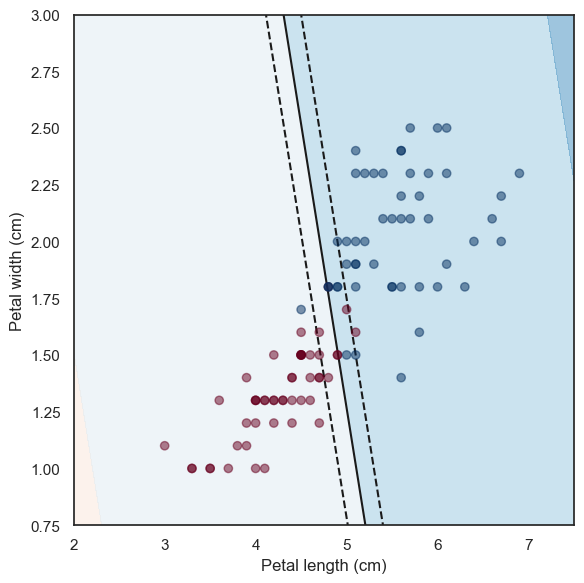

In [30]:
x_min = 2
x_max = 7.5
y_min = 0.75
y_max = 3

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# get the separating hyperplane
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 8)
yy = a * xx - (model.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(6, 6))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

plt.scatter( X[:, 0], X[:, 1], c=Y, zorder=10,  cmap=cm.get_cmap("RdBu"), alpha=0.5)

# Put the result into a contour plot
plt.axis("tight")
plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")

# Add a legend.
plt.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    cmap=cm.get_cmap("RdBu"),
)

plt.tight_layout()

Figure 4.12: A scatter plot of the Iris data set for the two classes representing the species Iris versicolor and Iris virginica. The decision boundary was computed using soft margin SVM classification, and shows the soft margin between the two classes.

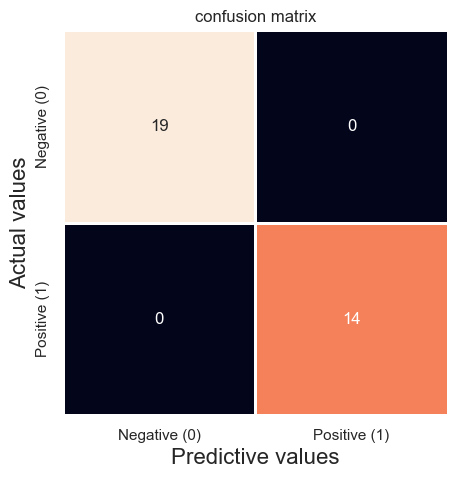

In [31]:
getConfusionMatrix(y_test_hard, y_pred_hard)

Figure 4.13: The confusion matrix for a hard margin SVM binary classifier trained on the Iris data with classes Iris versicolor and Iris setosa.

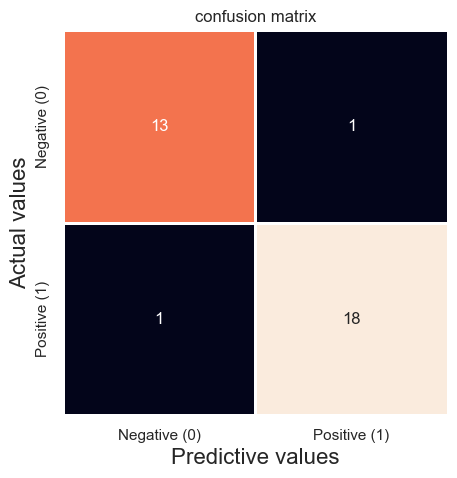

In [32]:
getConfusionMatrix(y_test_soft, y_pred_soft)

Figure 4.14: The confusion matrix for a soft margin SVM binary classifier, with C = 100, trained on the Iris data with classes Iris versicolor and Iris virginica.

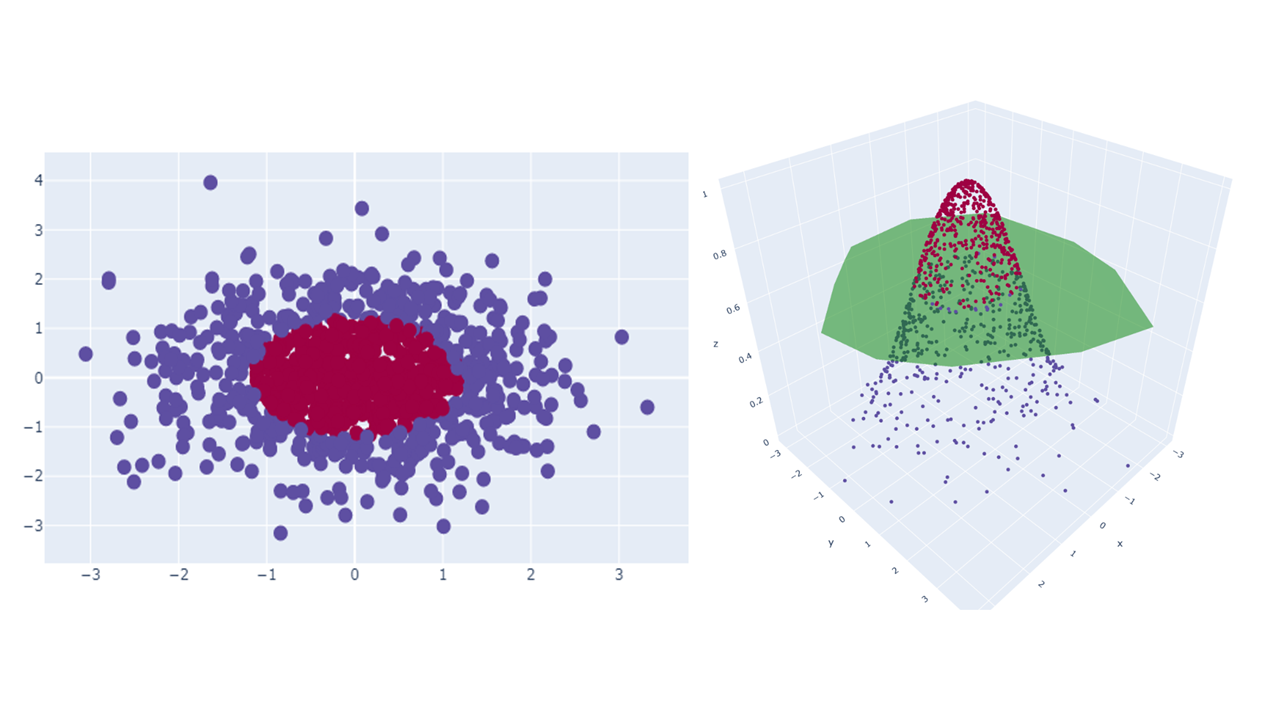

Figure 4.15: Example of SVM non-linear kernel; dense circle of data points surrounded by a ring of data points.

### 4.3.4 Decision Trees and Random Forests
**Example 4.7**: The heart disease data set, known as the Cleveland database, was compiled by medical several institutions. The data records 76 attributes about 303 patients, but published work has only referred to using a subset of 14 of them. These include amongst others: age, gender, where 0 is female and 1 is male, chest pain type (CP) experienced by the patient, using a range of integer values from 1 to 4 (1 = typical angina, 2 = atypical angina, 3 = non anginal pain and 4 = asymptotic), resting blood pressure (RBP) in millimeters of mercury (mmHg), cholesterol in milligrams per 100 millilitres (mg/dl), and diagnosis of whether the patient is suffering from heart disease or not, where 0 indicates absence (label= 0), and presence is indicated on a range from 1 to 4 (label> 0); see Table 4.14 for a sample from the data set. The confusion matrix summarising the performance of the decision tree model trained on the heart disease data set, is shown in Figure 4.20 and the precision, recall and F1 for the decision tree model are shown in stylised form in Table 4.15. Correspondingly, the confusion matrix for the random forest model applied to the heart disease data set is shown in igure 4.21 and the and the precision, recall and F1 for the random forest model are shown in stylised form in Table 4.16.

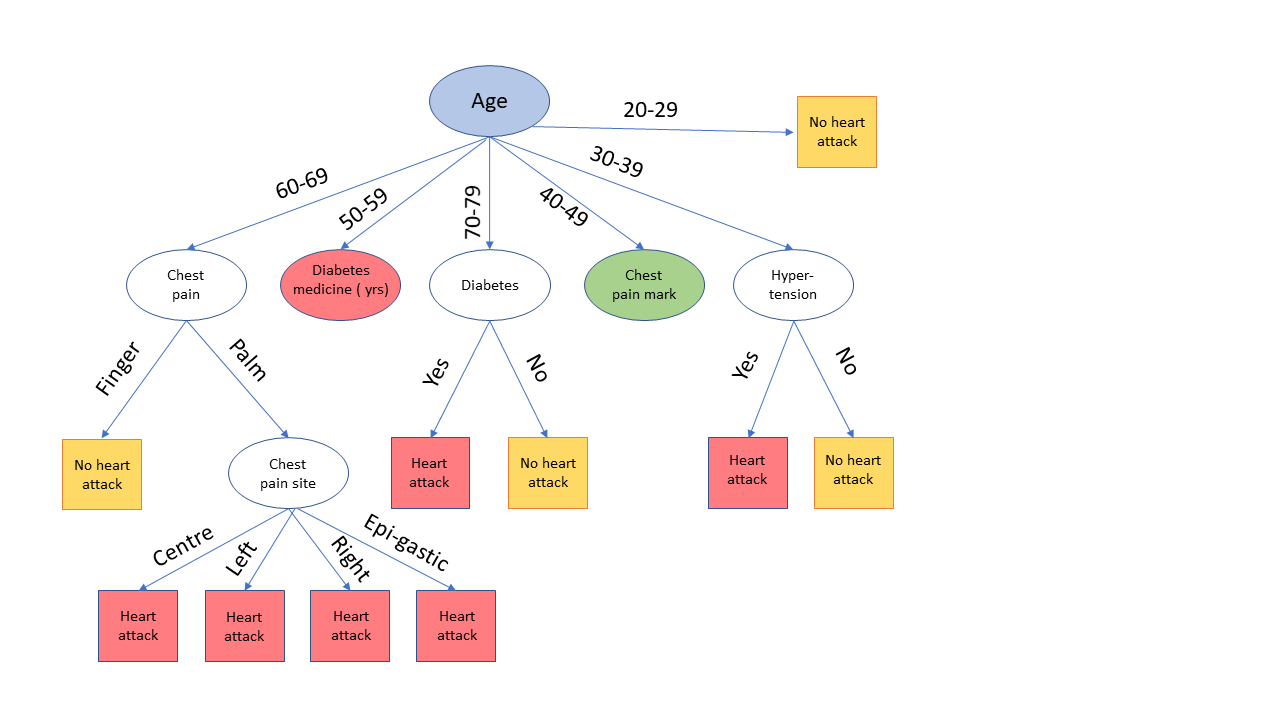
Figure 4.16: Example of a simple decision tree based on heart attack data.

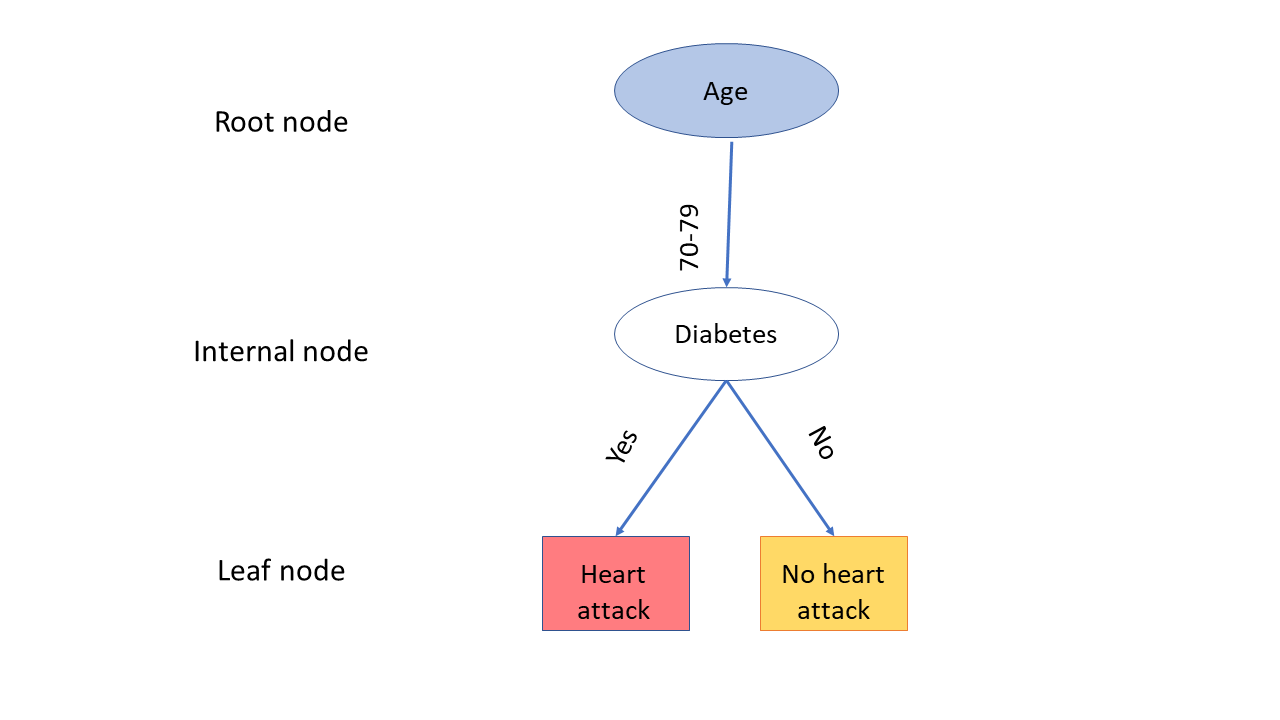
Figure 4.17: Node types in a tree data structure.

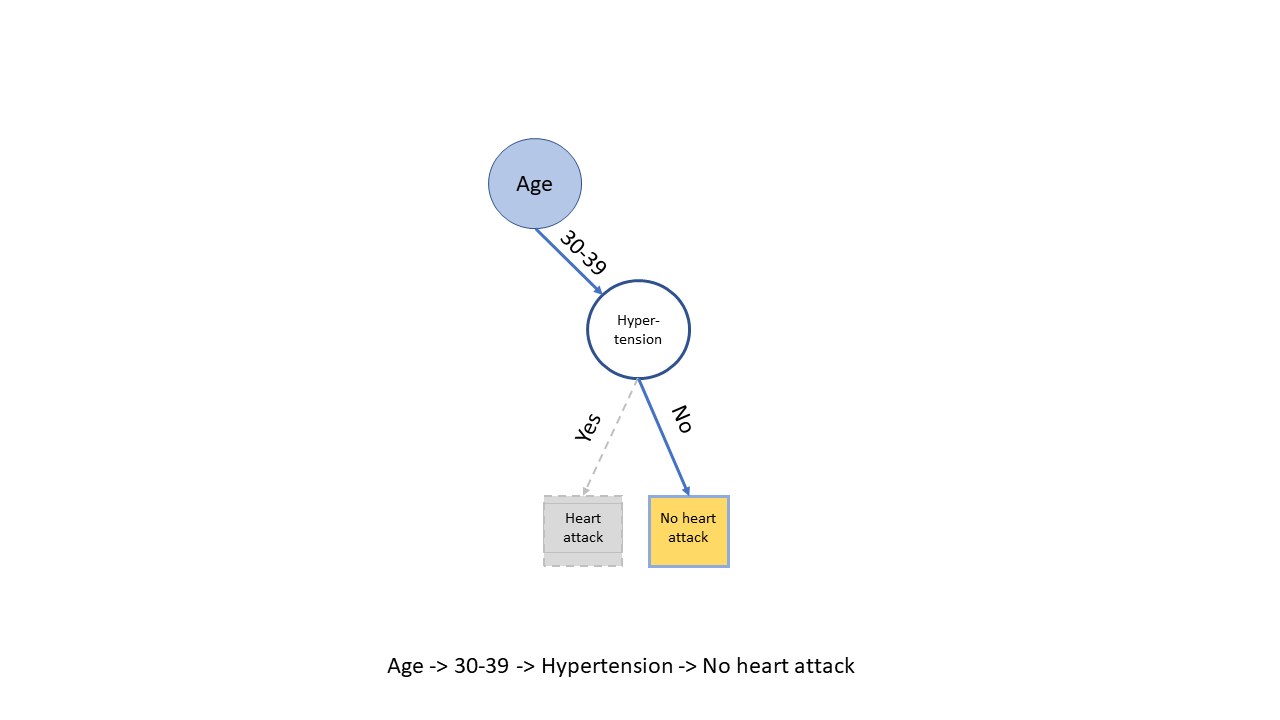
Figure 4.18: A path taken from the root node (labelled “Age”) through the internal node (labelled “Hypertension”) leading to the leaf node (labelled “No heart attack”).

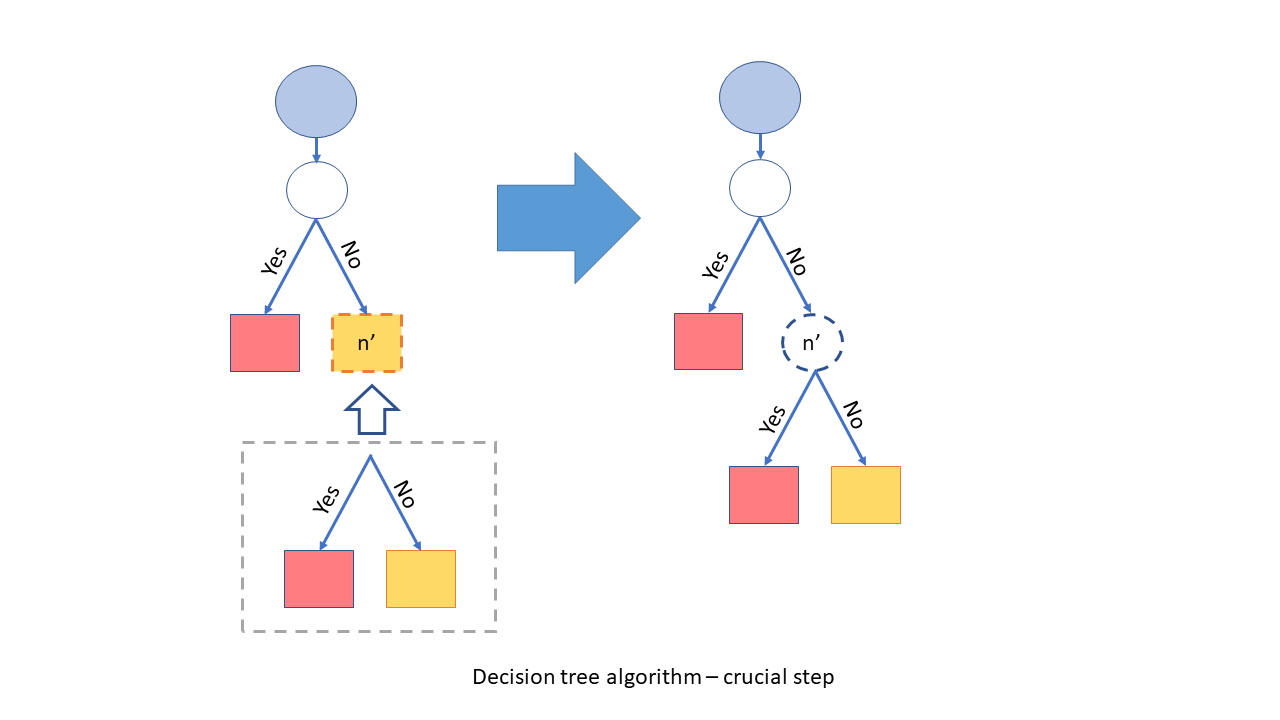


Figure 4.19: Crucial step of the decision tree construction algorithm.

In [33]:
df = pd.read_csv('./data/heart.csv')
print(df.head())

array = df.values
X = array[:,0:11]
y = array[:,12]

test_size = 0.33
seed = 7

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit a model
model = DecisionTreeClassifier(criterion = "gini")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

   age  gender  cp  RBP  cholesterol  fbs  restecg  thalach  exang  slope  \
0   29       1   1  130          204    0        0      202      0      2   
1   34       1   3  118          182    0        0      174      0      2   
2   34       0   1  118          210    0        1      192      0      2   
3   35       0   0  138          183    0        1      182      0      2   
4   35       1   1  122          192    0        1      174      0      2   

   diagnosis  thal  target  
0          0     2       1  
1          0     2       1  
2          0     2       1  
3          0     2       1  
4          0     2       1  


Table 4.14: A sample from the heart disease data set, where the diagnosis is made on a range of 0 to 4, with 0 indicating absence and 1 to 4 indicating presence in increasing severity; the class label is a binary variable, where 0 indicates absence of heart disease (i.e. diagnosis= 0) and a 1 indicates presence (i.e. diagnosis> 0). We use a 67-33 split between the training and test data for evaluation.

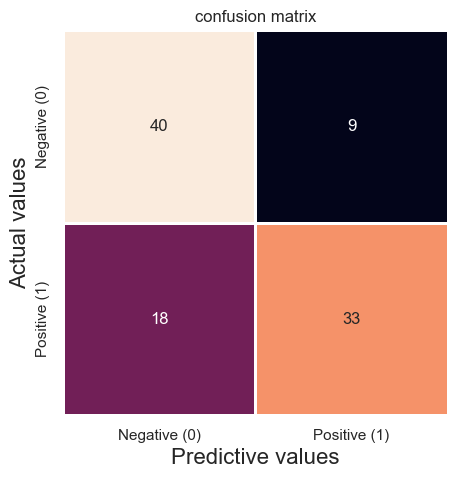

In [34]:
getConfusionMatrix(y_test, y_pred)

Figure 4.20: The confusion matrix for the decision tree classifier trained on the heart disease data set.

In [35]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        49
           1       0.79      0.65      0.71        51

    accuracy                           0.73       100
   macro avg       0.74      0.73      0.73       100
weighted avg       0.74      0.73      0.73       100

micro avg 0.73 0.73


Table 4.15: The precision, recall, and F1-score for a decision tree classifier applied to the heart disease data set. We use a 67-33 split between the training and test data for evaluation.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

model = RandomForestClassifier(n_estimators=1000,
                               max_depth=4,
                               criterion='gini',
                               random_state=66)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

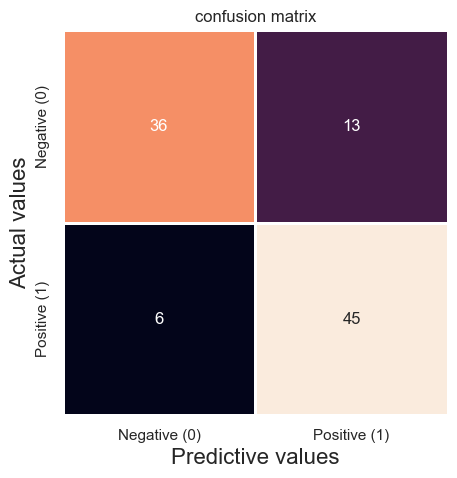

In [37]:
getConfusionMatrix(y_test, y_pred)

Figure 4.21: The confusion matrix for the random forest classifier trained on the heart disease data set.

In [38]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        49
           1       0.78      0.88      0.83        51

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

micro avg 0.81 0.81


Table 4.16: The precision, recall, and F1-score for a random forest classifier applied to the heart disease data set. We use a 67-33 split between the training and test data for evaluation.

### 4.3.5 Neural Networks and Deep Learning 
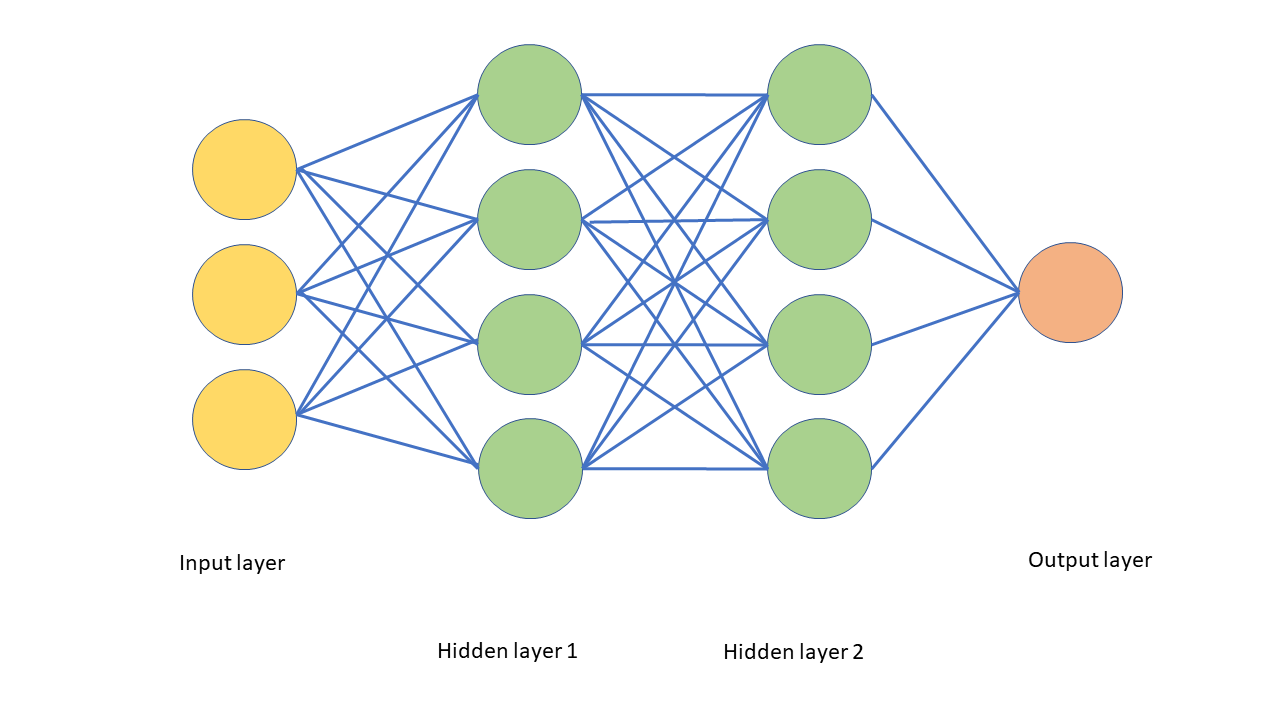

Figure 4.22: Example of a feedforward NN with two hidden layers.

<div class="alert alert-info" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"/>
        </div>
        <div class="col-xs-11">
            <strong>The evaluation results and values in the confusion matrix may vary from those in the book due to randomisation of the data, or where the notion of randomness is an inherent component of the algoritm itself.</strong>
        </div>
    </div>
</div>

**Example 4.8**: The Titanic data set describe the survival status of individual passengers on this tragic voyage. The data set contains records of the passengers who embarked on the voyage, including their passenger class (pclass), gender, age, the amount they paid for the fare (fare), and their cabin location if known (cabin). The class label, survived, indicates whether the passenger survived the disaster, labelled as 0, or did not survive, labelled by 1; see Table 4.17 for a sample from the data set.

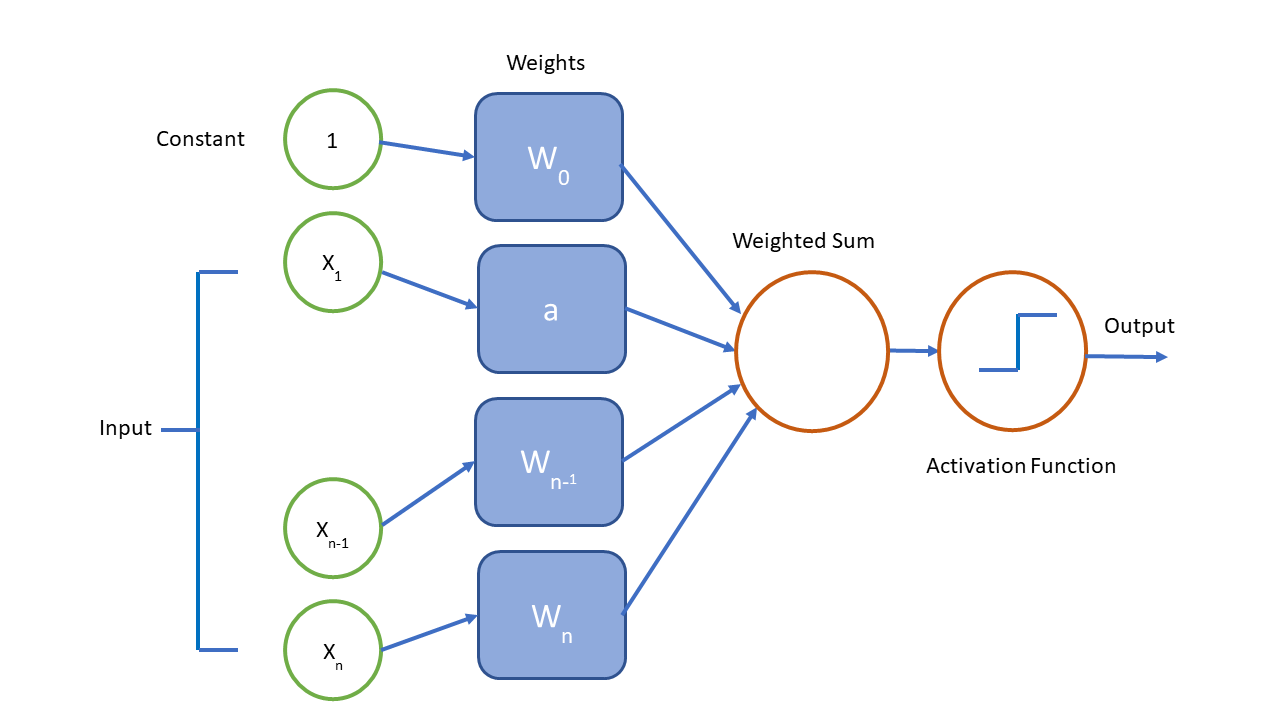
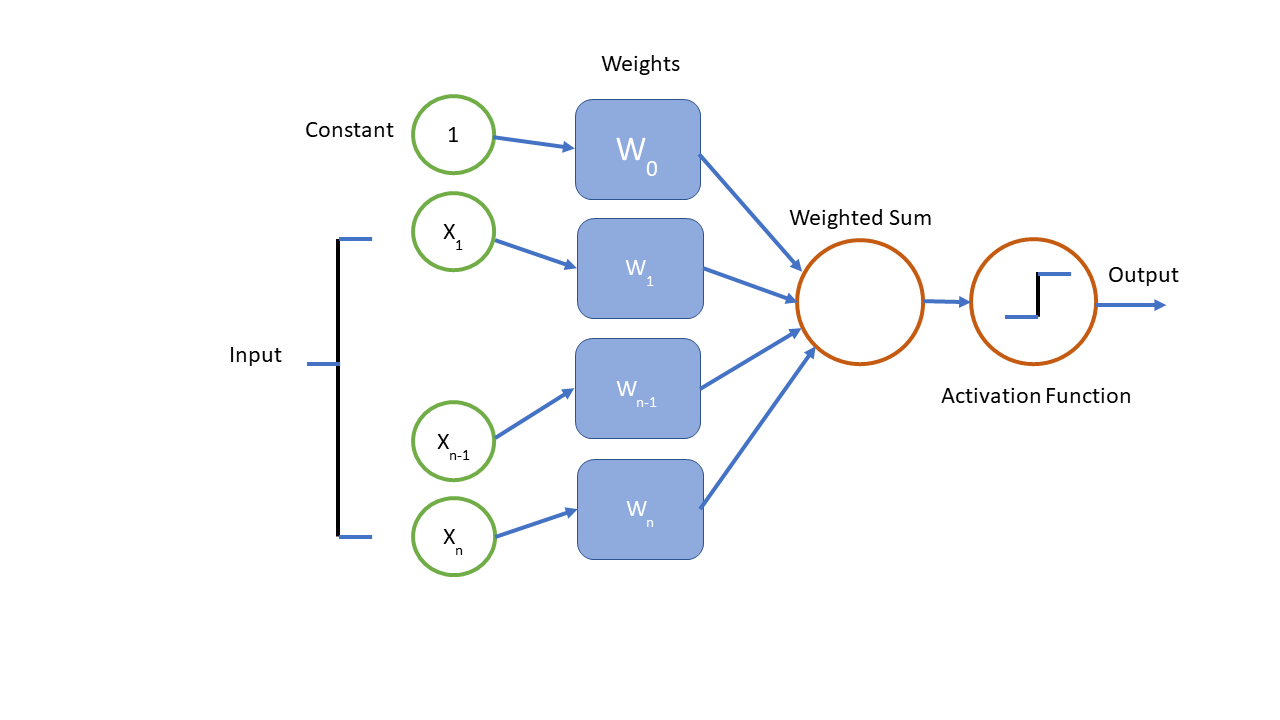

Figure 4.23: Example of a perceptron, i.e. a feedforward NN with no hidden layers

In [39]:
data = pd.read_csv("./data/titanic_train.csv", index_col='PassengerId')

X = data[['Pclass', 'Gender']]
y = data['Survived'].to_numpy()

print(data[['Pclass','Gender','Age','Fare','Cabin','Survived']].head())

             Pclass  Gender   Age     Fare Cabin  Survived
PassengerId                                               
1                 3       0  22.0   7.2500   NaN         0
2                 1       1  38.0  71.2833   C85         1
3                 3       1  26.0   7.9250   NaN         1
4                 1       1  35.0  53.1000  C123         1
5                 3       0  35.0   8.0500   NaN         0


Table 4.17: A sample from the Titanic data set recording attributes of the passengers who embarked on the voyage, including their passenger class, gender, age, amount paid in fares, and their cabin location if known. The class label, survived, is a binary variable, where 0 means a passenger did not survive the disaster and a 1 means they did survive.

In [40]:
# Instantiate the model
Perceptron()
model = Perceptron(random_state=seed)

test_size = 0.33
seed = 18

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [41]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       181
           1       0.65      0.81      0.72       114

    accuracy                           0.76       295
   macro avg       0.75      0.77      0.75       295
weighted avg       0.78      0.76      0.76       295

micro avg 0.7559322033898305 0.7559322033898305


Table 4.18: The precision, recall, and F1-score for the perceptron with a 67-33 split between the training and test data, which was used to classify those passengers who survived (label 1) the Titanic voyage, and those who did not survive (label 0).

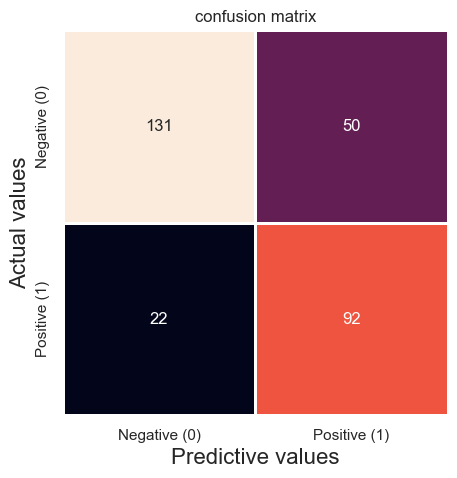

In [42]:
getConfusionMatrix(y_test, y_pred)

Figure 4.24: The confusion matrix for the perceptron trained on the Titanic data set.

In [43]:
test_size = 0.33
seed = 18

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True)

# define the keras model
model = Sequential()
model.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=0)

# make class predictions with the model
y_pred = (model.predict(X_test, batch_size=10) > 0.5).astype(int)





30/30 [==============================] - 0s 1ms/step


In [44]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       181
           1       0.74      0.68      0.71       114

    accuracy                           0.78       295
   macro avg       0.77      0.76      0.77       295
weighted avg       0.78      0.78      0.78       295

micro avg 0.7830508474576271 0.7830508474576271


Table 4.19: The precision, recall, and F1-score for a feedforward neural network with **one** hidden layer, with 12 neurons, with a 67-33 split between the training and test data, , which was used to classify those passengers who survived (label 1) the Titanic voyage, and those who did not survive (label 0).

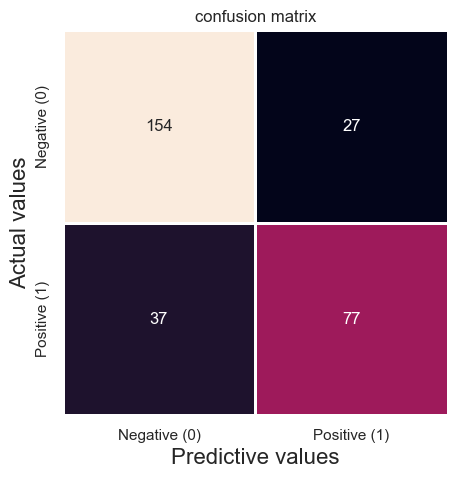

In [45]:
getConfusionMatrix(y_test, y_pred)

Figure 4.25: The confusion matrix for a feedforward neural network with **one** hidden layer trained on the Titanic data set.

In [46]:
# define the keras model
model = Sequential()
model.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='relu')) # hidden layer 1
model.add(Dense(12, activation='relu')) # hidden layer 2
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=10, verbose=0)

# make class predictions with the model
y_pred = (model.predict(X_test, batch_size=10)>0.5).astype(int)

30/30 [==============================] - 0s 2ms/step


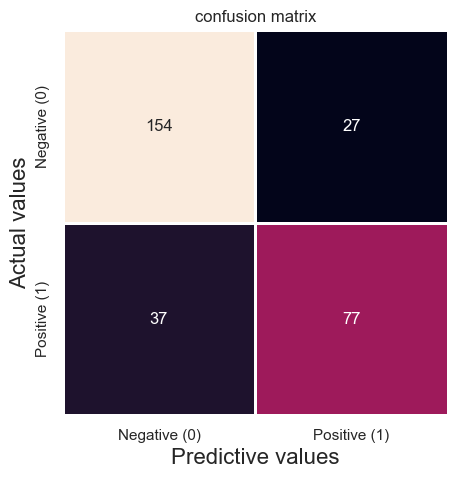

In [47]:
getConfusionMatrix(y_test, y_pred)

Figure 4.26: The confusion matrix for a feedforward neural network with **two** hidden layers trained on the Titanic data set.

In [48]:
getEvaluationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       181
           1       0.74      0.68      0.71       114

    accuracy                           0.78       295
   macro avg       0.77      0.76      0.77       295
weighted avg       0.78      0.78      0.78       295

micro avg 0.7830508474576271 0.7830508474576271


Table 4.20: The precision, recall, and F1-score for a feedforward neural network with **two** hidden layers, each with 12 neurons, with a 67-33 split between the training and test data, which was used to classify those passengers who survived (label 1) the Titanic voyage, and those who did not survive (label 0).

## Convolutional Neural Network
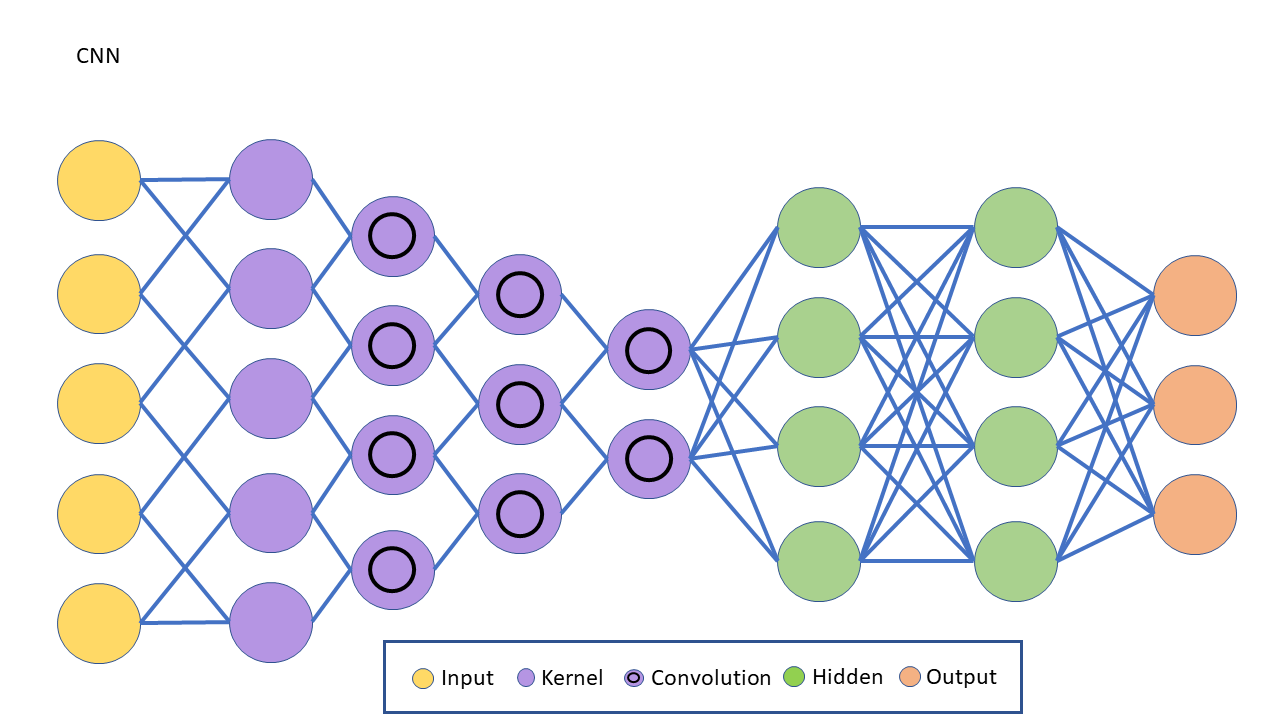

Figure 4.27: Example of a convolutional neural network (CNN).

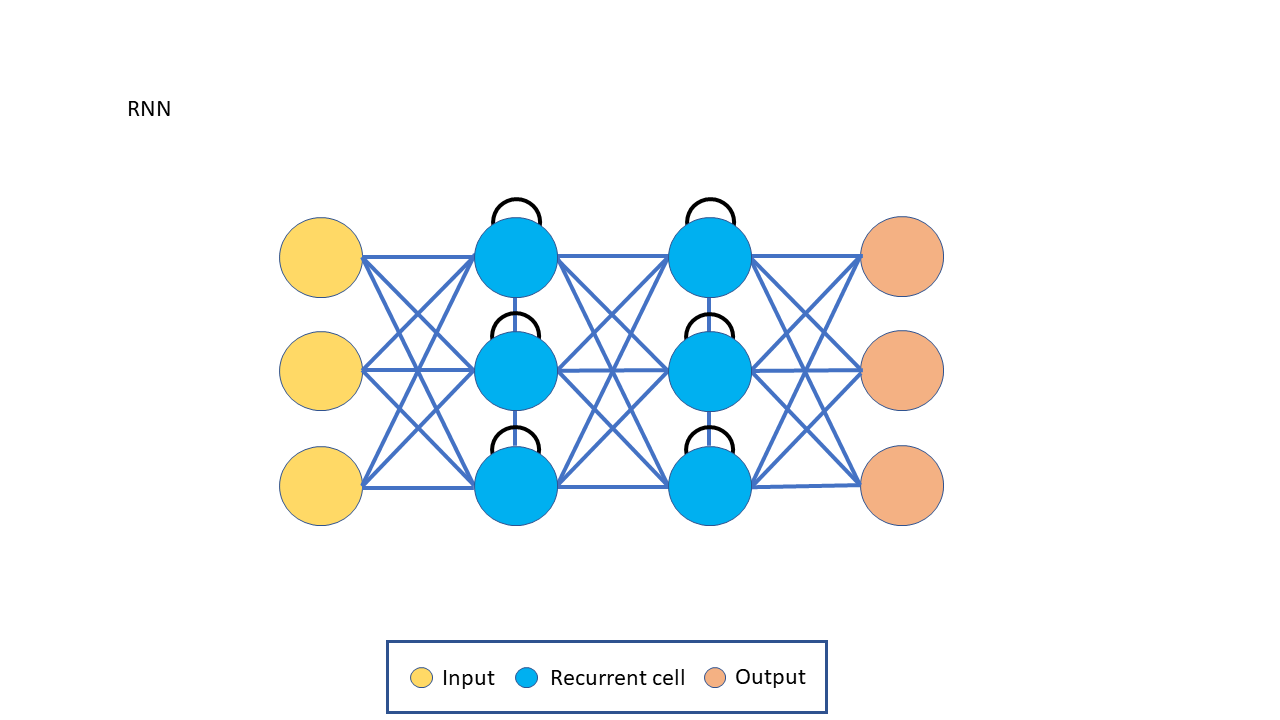

Figure 4.28: Example of a recurrent neural network (RNN).

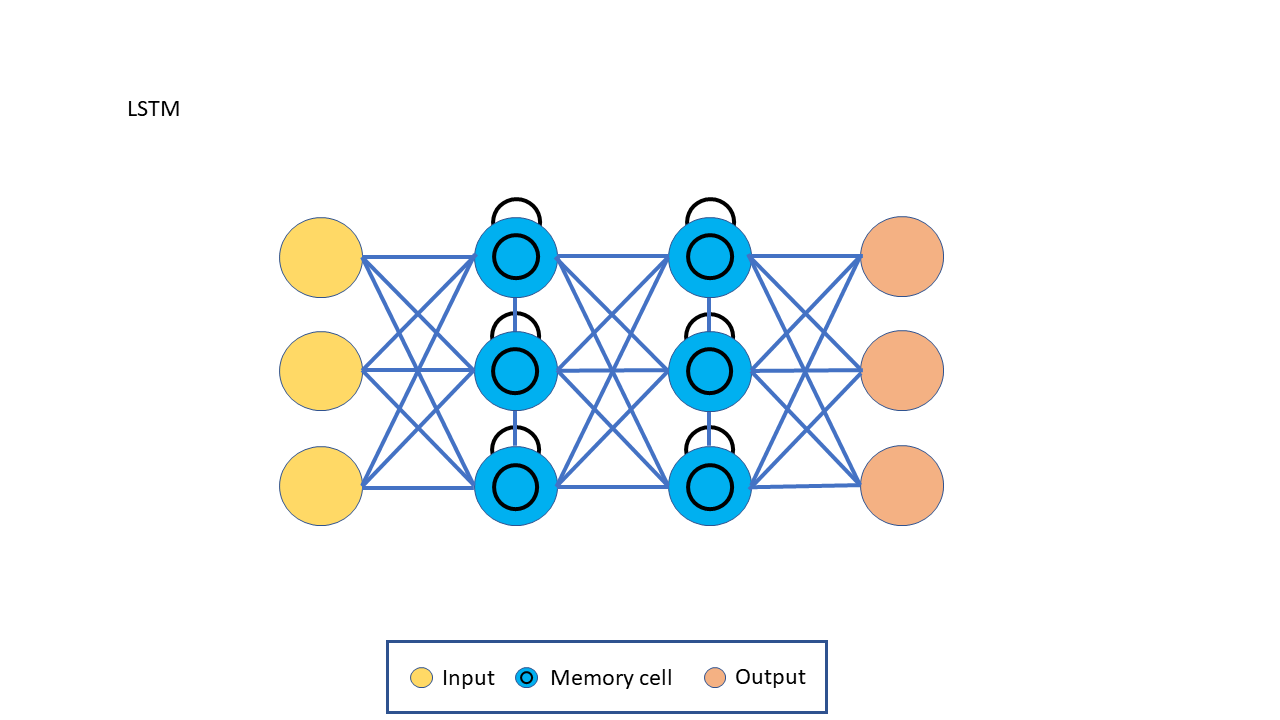

Figure 4.29: Example of a long short-term memory (LSTM) NN.

## 4.4 Unsupervised Methods

### 4.4.1 K-Means
**Example 4.9**: We reuse the heart disease data set, with the sample data shown in Table 4.14. The elbow plot or k-means applied to this data set is shown in Figure 4.30, indicating that k = 3 is the optimal number of clusters for this data set.

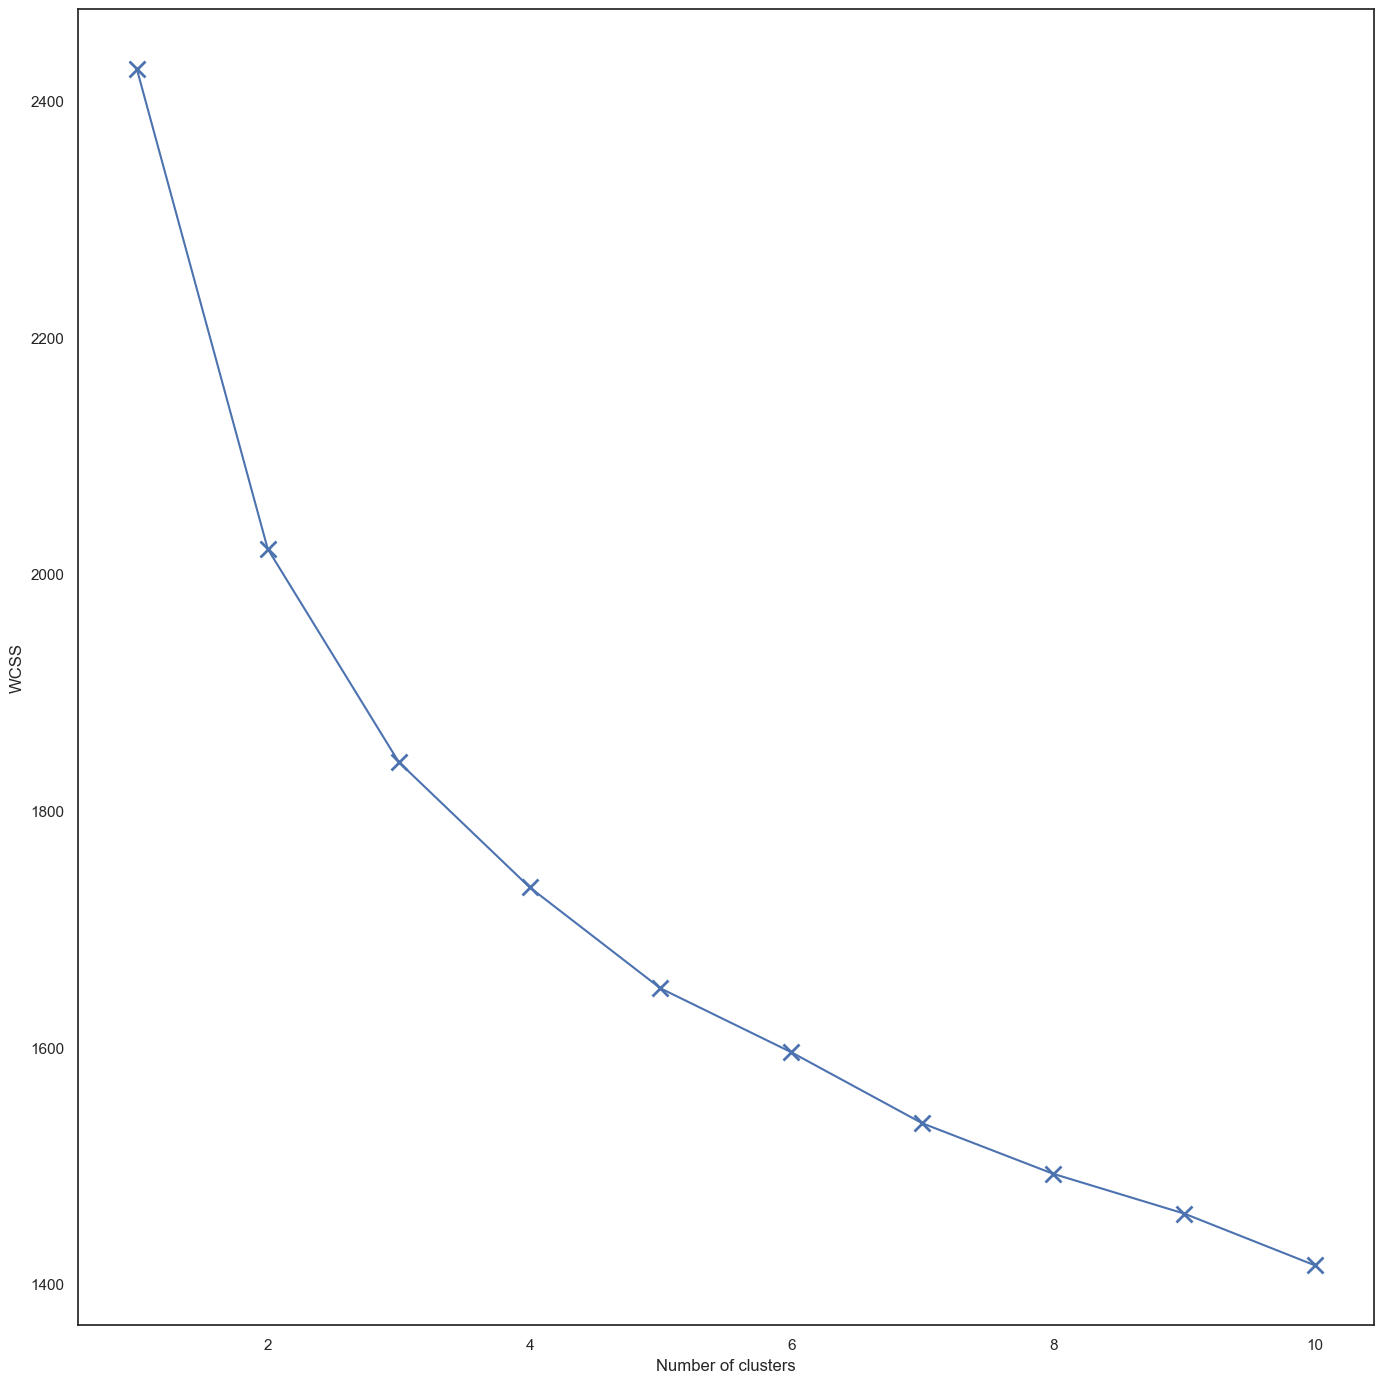

In [49]:
dataset = pd.read_csv('./data/heart.csv')

# preprocess
dataset = pd.get_dummies(dataset, columns = ['gender', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'diagnosis', 'thal'])

standardScaler = StandardScaler()

columns_to_scale = ['age', 'RBP', 'cholesterol', 'thalach']

dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])

y = dataset['target']
X = dataset.drop(['target'], axis = 1)

wcss = []
labels = set()
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    label = kmeans.fit(X)
    labels.add(label)
    
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss,'-x', markersize=12, markeredgewidth=2)

plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.tight_layout()

Figure 4.30: Elbow plot for k-means applied to the heart disease data set, with the number of clusters along the x-axis and the SSE on the y-axis.

### 4.4.2 Hierarchical Clustering
**Example 4.10**: We illustrate HAC by clustering the Iris data set, this time with classes for three species, the Iris setosa, Iris versicolour and Iris virginica, employing the Euclidean distance measure. For each Iris species the discovered clusters are based on four features: petal length an d width, and sepal length and width. In doing so we will also demonstrate the use of the dendrogram to display the resulting clustering in a tree format.

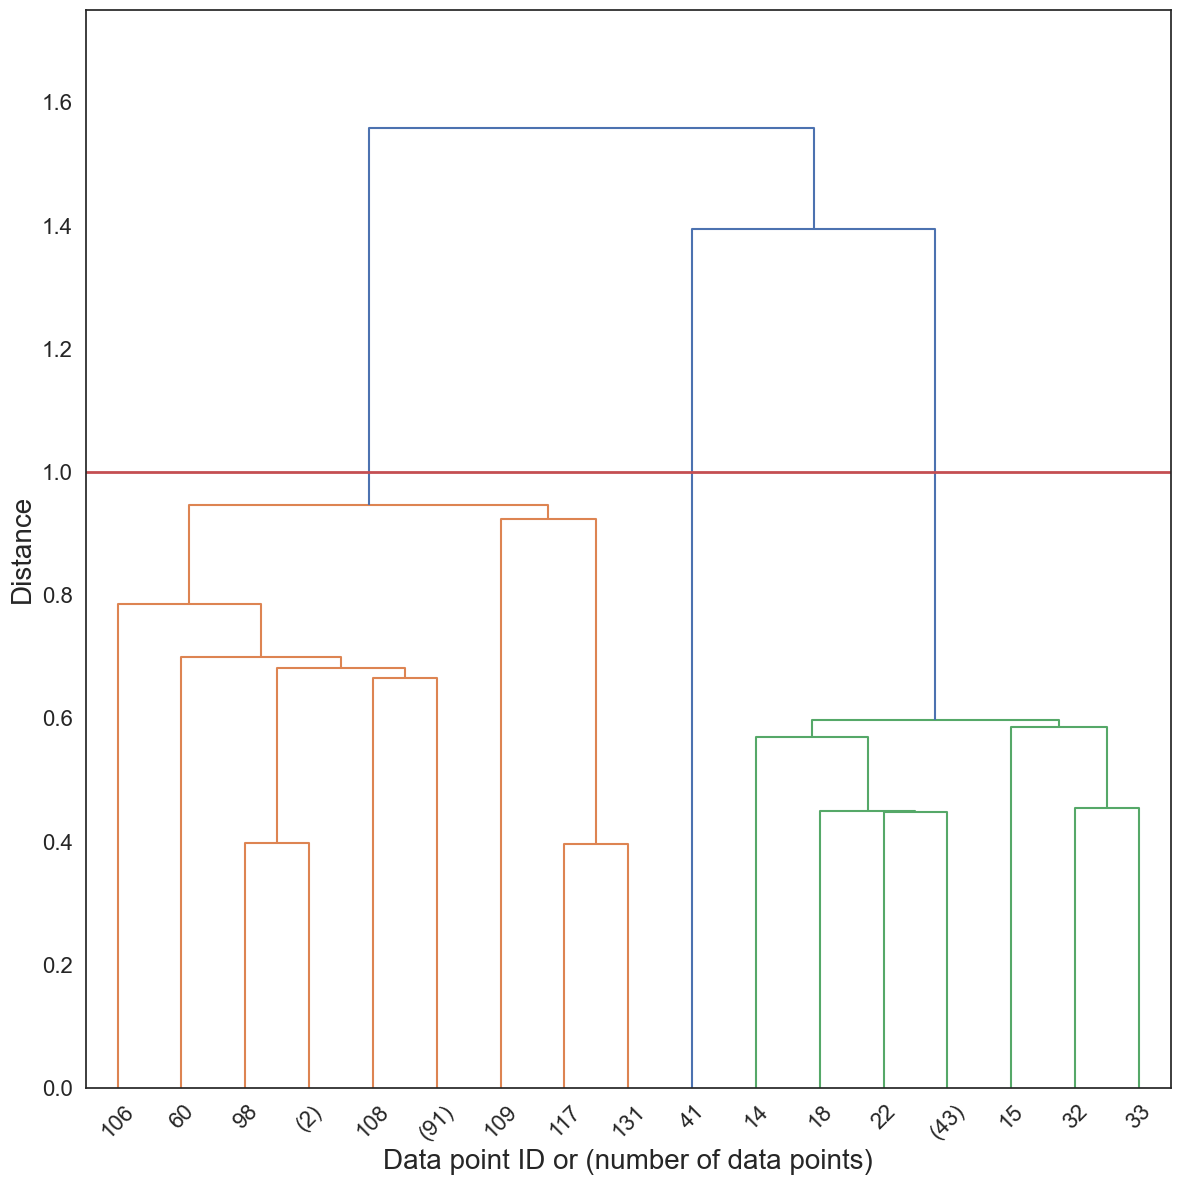

In [50]:
df = pd.DataFrame(load_iris()['data'])

scaled_data = whiten(df.to_numpy())

# Use the linkage() function
distance_matrix = linkage(scaled_data, method = 'single', metric = 'euclidean')

# Create a dendrogram
dn = dendrogram(distance_matrix, truncate_mode="level", p=5)

ax = plt.gca()
ax.set_xlabel("Data point ID or (number of data points)", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim([0, 1.75])

plt.grid(False)
plt.axhline(y=1, color='r', linestyle='-', lw=2)
plt.xticks(rotation = 45)

# Assign cluster labels
df['cluster_labels'] = fcluster(distance_matrix, 3, criterion='maxclust')

Figure 4.31: A dendrogram of HAC applied to the Iris data set using the single-link method. The x-axis is labelled with the data point id (if it is an initial cluster) or the number of data points in the cluster (in brackets), and the y-axis represents the distance between two clusters being merged.

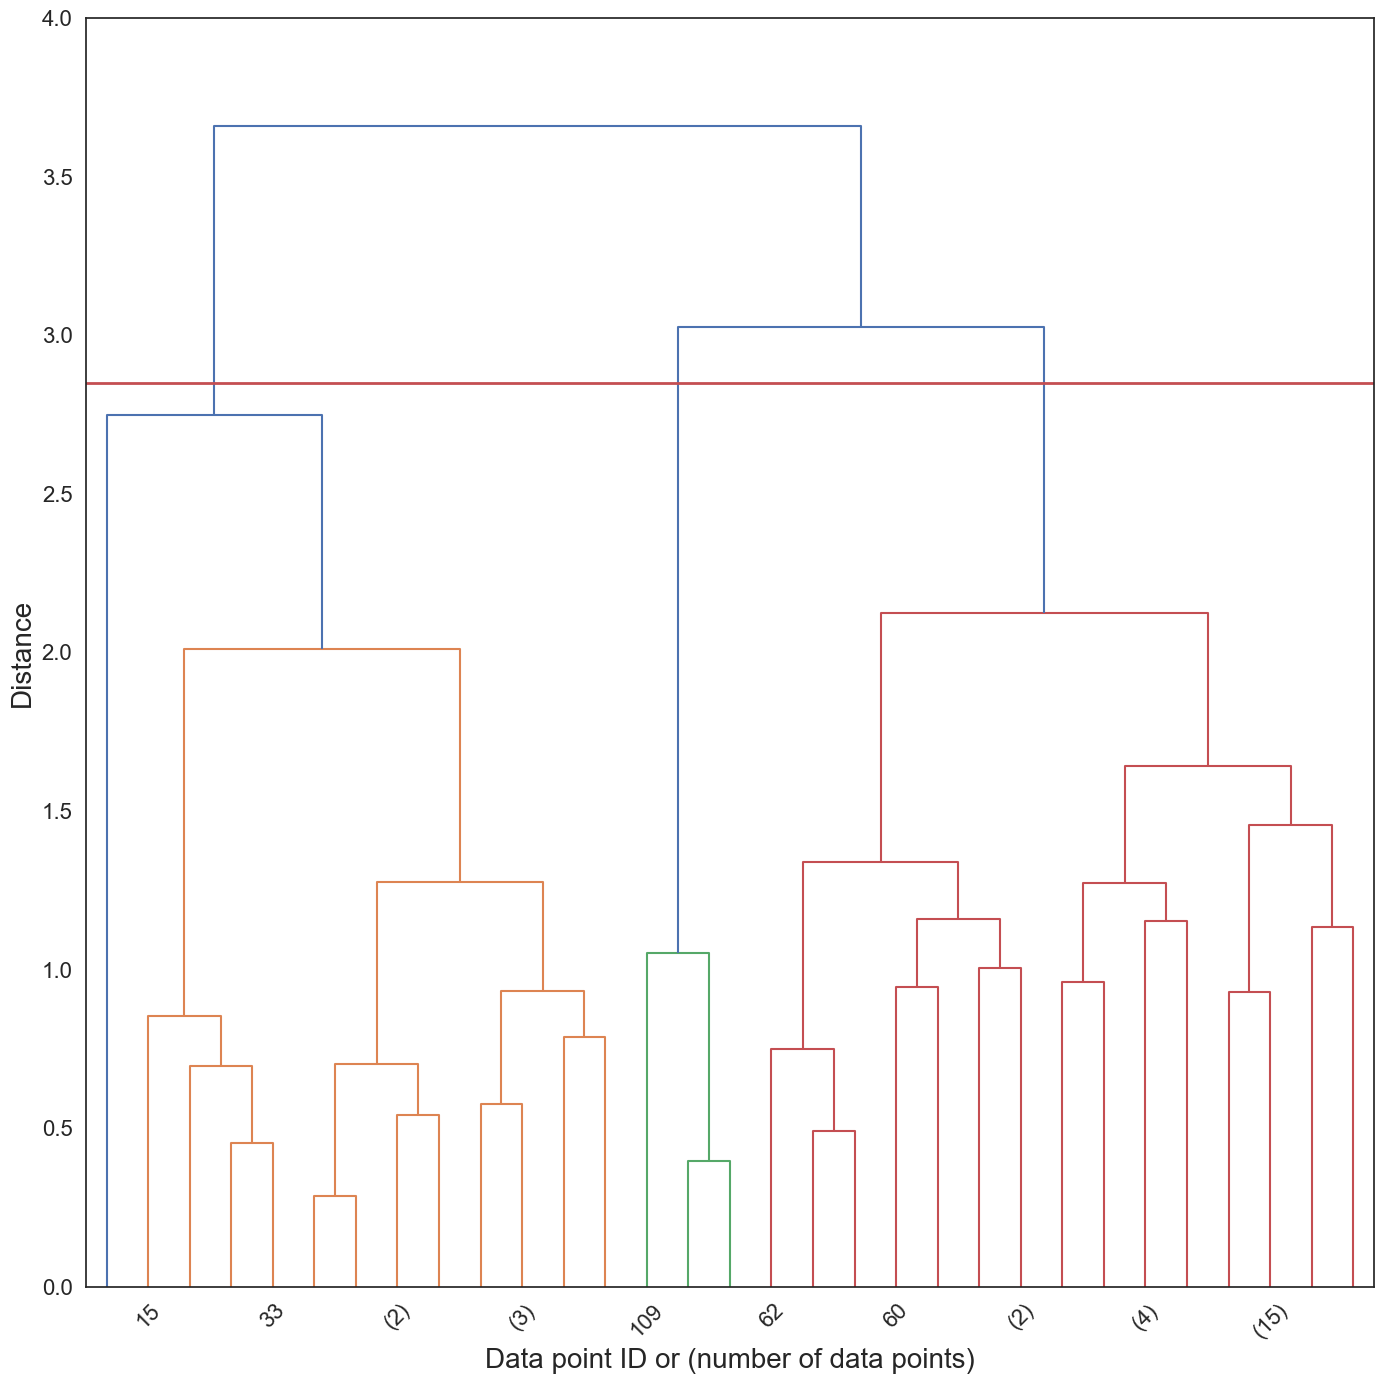

In [51]:
distance_matrix = linkage(scaled_data, method = 'average', metric = 'euclidean')

# Create a dendrogram
dn = dendrogram(distance_matrix, truncate_mode="level", p=5)

ax = plt.gca()

ax.set_xlabel("Data point ID or (number of data points)", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)

ax.set_ylim([0,4])
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.tick_params(axis='both', which='major', labelsize=16)

# Assign cluster labels
df['cluster_labels'] = fcluster(distance_matrix, 3, criterion='maxclust')

plt.grid(False)
plt.axhline(y=2.85, color='r', linestyle='-', lw=2)
plt.xticks(rotation = 45)

plt.tight_layout()

Figure 4.32: A dendrogram of HAC applied to the Iris data set using the average-link method. The x-axis is labelled with the data point id (if it is an initial cluster) or the number of data points in the cluster (in brackets), and the y-axis represents the distance between two clusters being merged.

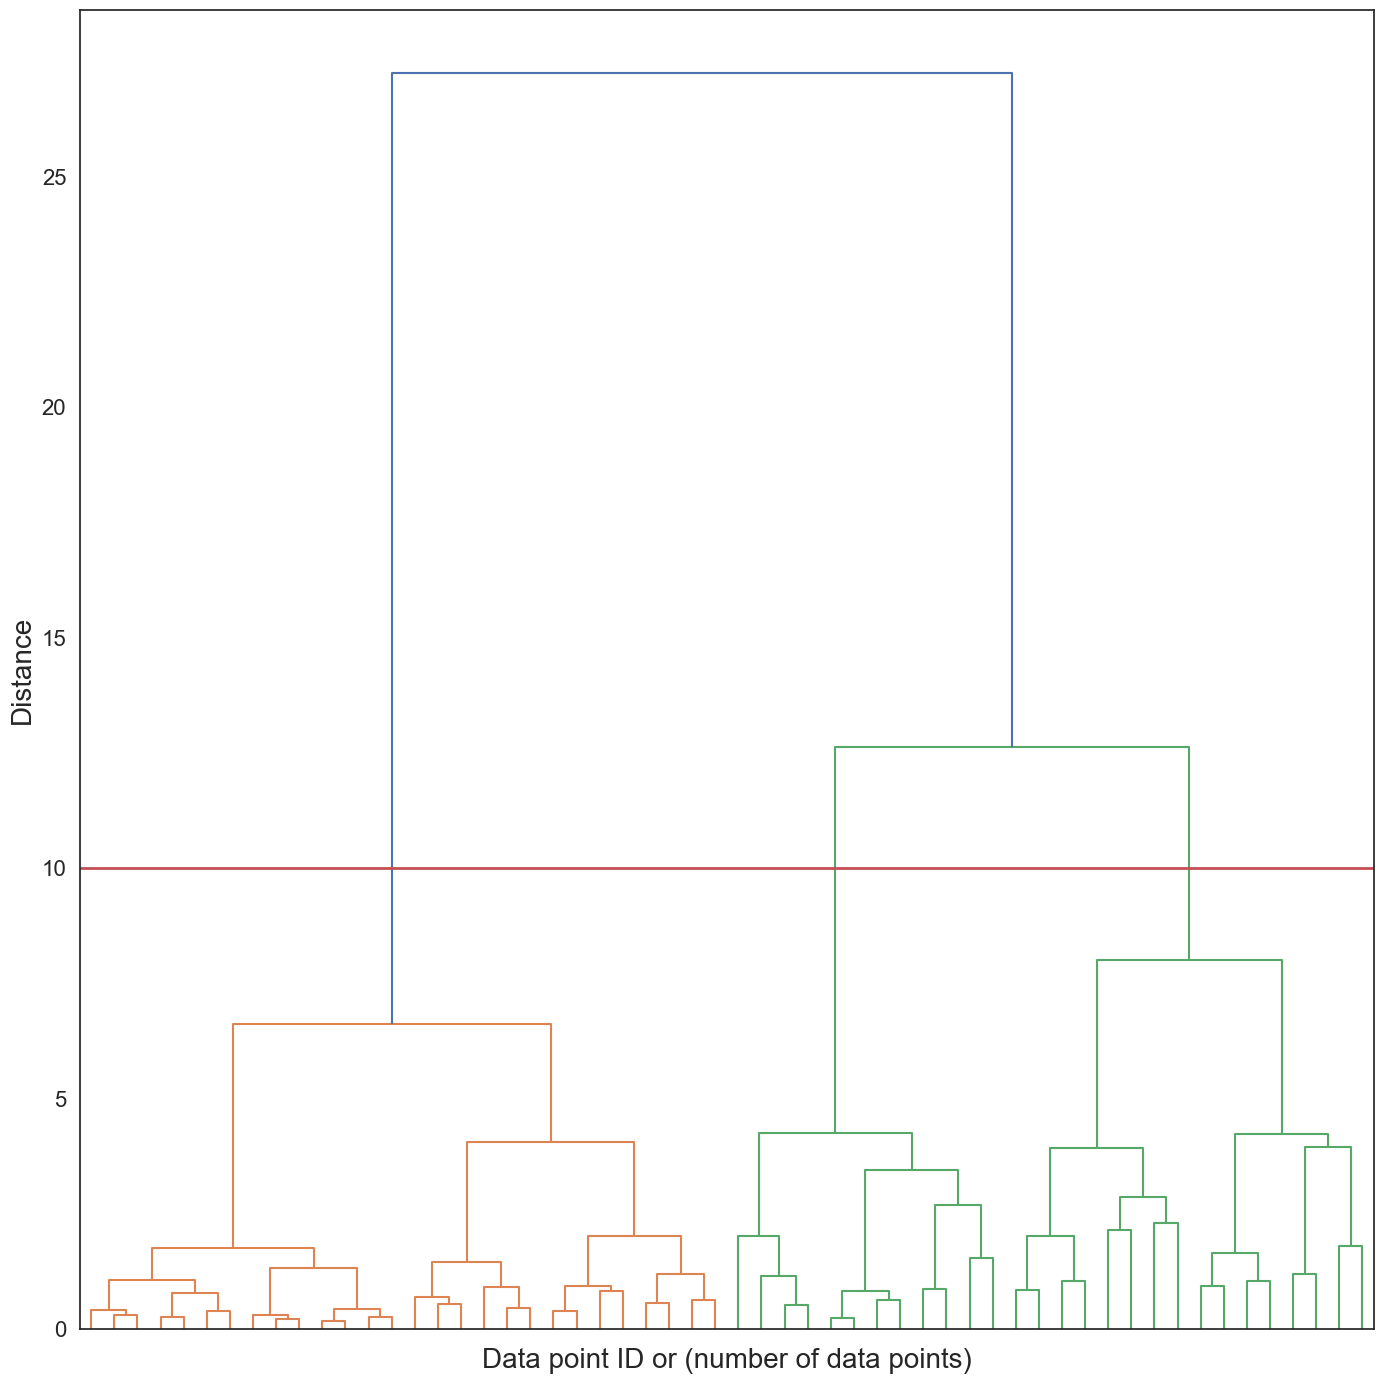

In [52]:
# Use the linkage() function
distance_matrix = linkage(scaled_data, method = 'ward', metric = 'euclidean')

# Create a dendrogram
dn = dendrogram(distance_matrix, truncate_mode="level", p=5)

# Assign cluster labels
df['cluster_labels'] = fcluster(distance_matrix, 3, criterion='maxclust')

ax = plt.gca()
ax.set_xlabel("Data point ID or (number of data points)", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.tick_params(axis='both', which='major', labelsize=16)

plt.grid(False)
plt.axhline(y=10, color='r', linestyle='-', lw=2)
plt.xticks(rotation = 45)

plt.tight_layout()

Figure 4.33: A dendrogram of HAC applied to the Iris data set using Ward’s linkage method. The x-axis is labelled with the data point id (if it is an initial cluster) or the number of data points in the cluster (in brackets), and the y-axis represents the distance between two clusters being merged.

### 4.4.3 Principal Components Analysis
**Example 4.11**: The data set described features from scans of breast cancer patients recording the mean radius, texture, perimeter, and area of breast tissue; a sample from the data is shown in Table 4.21. The last column in the represents whether the diagnosis is labelled benign or malignant.

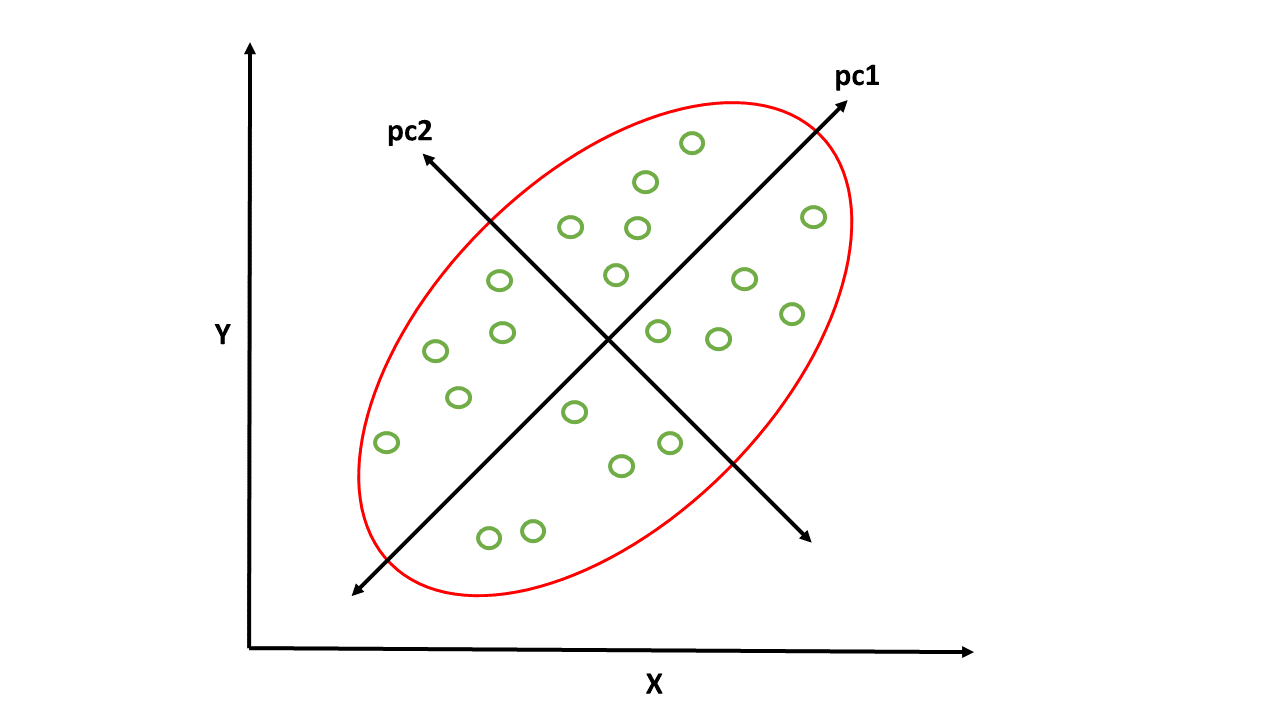

Figure 4.34: Example of PCA in two dimensions. The x-axis is labelled by PC1, the first principal component, while the y-axis is labelled by PC2, the second principal component.

In [53]:
breast_dataset = load_breast_cancer()
breast_data = breast_dataset.data
breast_labels = breast_dataset.target

labels = np.reshape(breast_labels,(569,1))

final_breast_data = np.concatenate([breast_data,labels],axis=1)
final_breast_data.shape

df = pd.DataFrame(final_breast_data)
features = breast_dataset.feature_names

# Add label for the training instances column
features_labels = np.append(features,'label')
df.columns = features_labels

df['label'].replace(0, 'benign',inplace=True)
df['label'].replace(1, 'malignant',inplace=True)

df['marker'] = ""

print(df[['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'label']].head())

   mean radius  mean texture  mean perimeter  mean area   label
0        17.99         10.38          122.80     1001.0  benign
1        20.57         17.77          132.90     1326.0  benign
2        19.69         21.25          130.00     1203.0  benign
3        11.42         20.38           77.58      386.1  benign
4        20.29         14.34          135.10     1297.0  benign


Table 4.21: A sample from the breast cancer data, where the class label representing the diagnosis is either benign or malignant.

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4')])

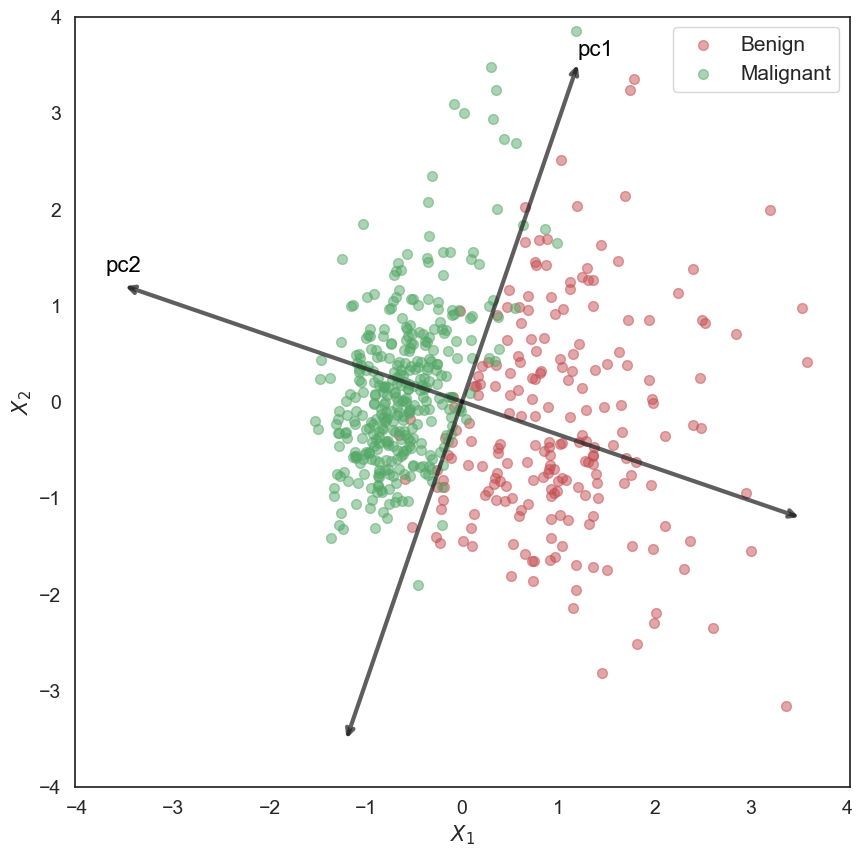

In [54]:
# Helper function to draw the direction of the vectors:
def draw_vector(v0, v1, ax=None, color='k', label=""):
    arrowprops=dict(arrowstyle='->',
                    linewidth=3,
                    shrinkA=0, shrinkB=0, color=color, alpha=0.7)
    ax.annotate("", v1, v0, arrowprops=arrowprops)

plt.figure(figsize=(10,10))

X = df.loc[:, features].values

feature_columns = ['feature' + str(i) for i in range(X.shape[1])]

normalised_breast = pd.DataFrame(X, columns=feature_columns)

# Z-score the features
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

model = PCA(n_components=2, whiten=True)
model.fit(X)

# plot principal components
X_pca = model.transform(X)

targets = ['benign', 'malignant']
colors = ['r', 'g']

markers = np.array(['o','x']) 

df_PCA = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])

c = 1
components1 = []
components2 = []

for feature_importance in model.components_:
    i = 0
    for n in feature_importance:
        if c==1:
            components1.append([features_labels[i], feature_importance[i]])
        else:
            components2.append([features_labels[i], feature_importance[i]])
        i+=1
    c+=1

df_components1 = pd.DataFrame(components1, columns=["feature", "score"])
df_components1.sort_values("score", ascending=False, inplace=True)

df_components2 = pd.DataFrame(components2, columns=["feature", "score"])
df_components2.sort_values("score", ascending=False, inplace=True)

for target, color in zip(targets, colors):
    indicesToKeep = df['label'] == target
    plt.scatter(df_PCA.loc[indicesToKeep, 'principal component 1'], df_PCA.loc[indicesToKeep, 'principal component 2'], c = color, s = 50, alpha=0.5)

ax = plt.gca()
draw_vector([0, 0], [1.2, 3.5], ax, 'k',)
draw_vector([0, 0], [3.5, -1.2], ax, 'k')


ax.annotate('pc1', xy=(0,0), xytext=(1.2, 3.6), fontsize=16, color='black')
ax.annotate('pc2', xy=(0,0), xytext=(-3.7, 1.35), fontsize=16, color='black')

draw_vector([0, 0], [-1.2, -3.5], ax, 'k',)
draw_vector([0, 0], [-3.5, 1.2], ax, 'k')

plt.xlabel("$X_{}$".format(1), fontsize=15)
plt.ylabel("$X_{}$".format(2), fontsize=15)
plt.legend([t.title() for t in targets], prop={'size': 15})

ax.axis('equal')
plt.ylim([-4, 4])
plt.xlim([-4, 4])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Figure 4.35: A scatter plot of the data points in the breast cancer data set associated with the two principle components. An in Figure 4.34 the x-axis is labelled by PC1, the first principal component, while the y-axis is labelled by PC2, the second principal component.

### 4.4.4 Topic Modelling
**Example 4.12**: The ABC news data set contains a corpus of news articles covering twenty topics, including computer hardware, items for sale and religion; see Table 4.22 for a sample from the data set. We apply NMF to the data set generating 20 topics, and plot, in Figure 4.37, four of the twenty topics with their top-10 words ordered by weight. Topic 1 does not appear to be well-defined, and may represent general news stories. On the other hand, topic 2 is defined by words that are associated with war and conflict. Topic 3 appears to describe computer technology and software, while topic 4 describes news stories around space exploration. In Figure 4.38 we show the topic coherence plot for the number of topics ranging from k = 2 to k = 30 for the NMF model, where k indicates the number of generated topics. The topic coherence on the y-axis is the average of the topic coherence scores for the k topics generated by the NMF model. The plot demonstrates that k = 20 topics are sufficient for describing the corpus due to the high coherence score for k = 20 in the plot.

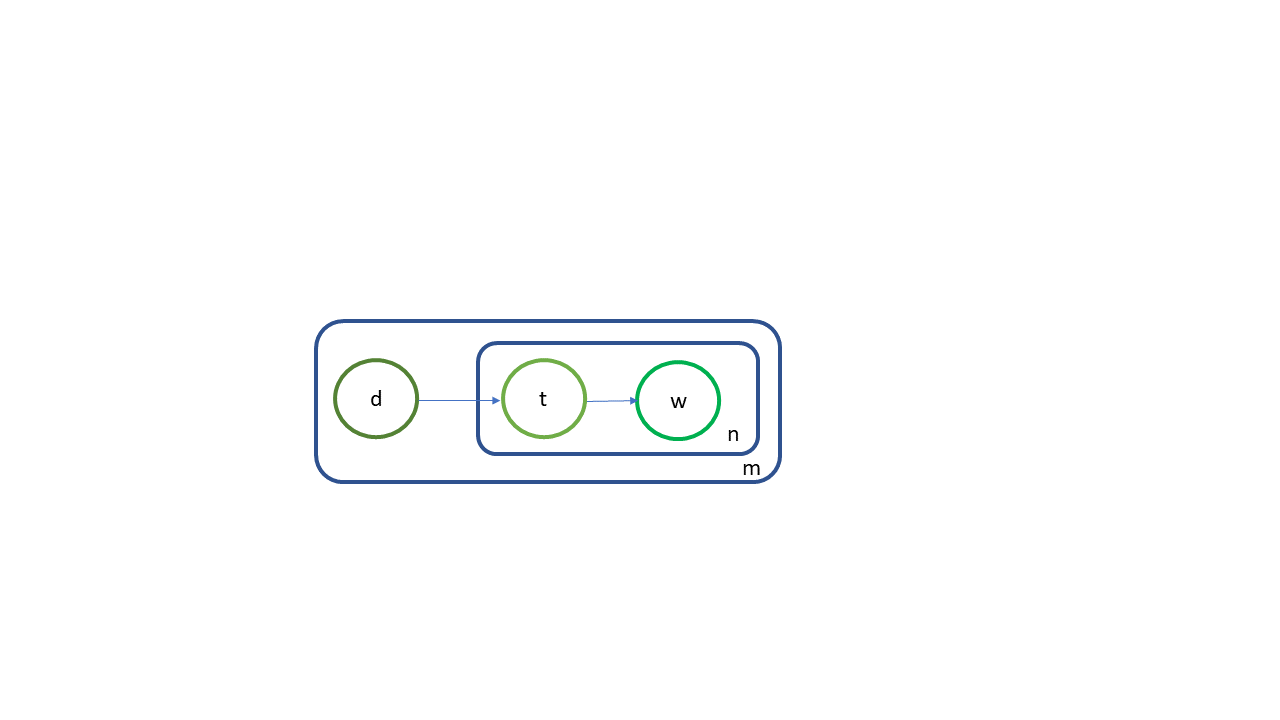

Figure 4.36: Graphical model plate notation for probabilistic latent sematic analysis (PLSA).

In [55]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'the'])

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]

print(df.head())

                                              content  target  \
10  From: irwin@cmptrc.lonestar.org (Irwin Arnstei...       8   
21  From: leunggm@odin.control.utoronto.ca (Gary L...      10   
28  From: jonh@david.wheaton.edu (Jonathan Hayward...      15   
33  From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...      17   
35  From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...      10   

              target_names  
10         rec.motorcycles  
21        rec.sport.hockey  
28  soc.religion.christian  
33   talk.politics.mideast  
35        rec.sport.hockey  


Table 4.22: A sample from the news-group data set showing the date of publication and headline text of ABC news articles.

done in 0.000s.
Extracting tf-idf features for NMF...
done in 0.331s.


 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 3.210s.


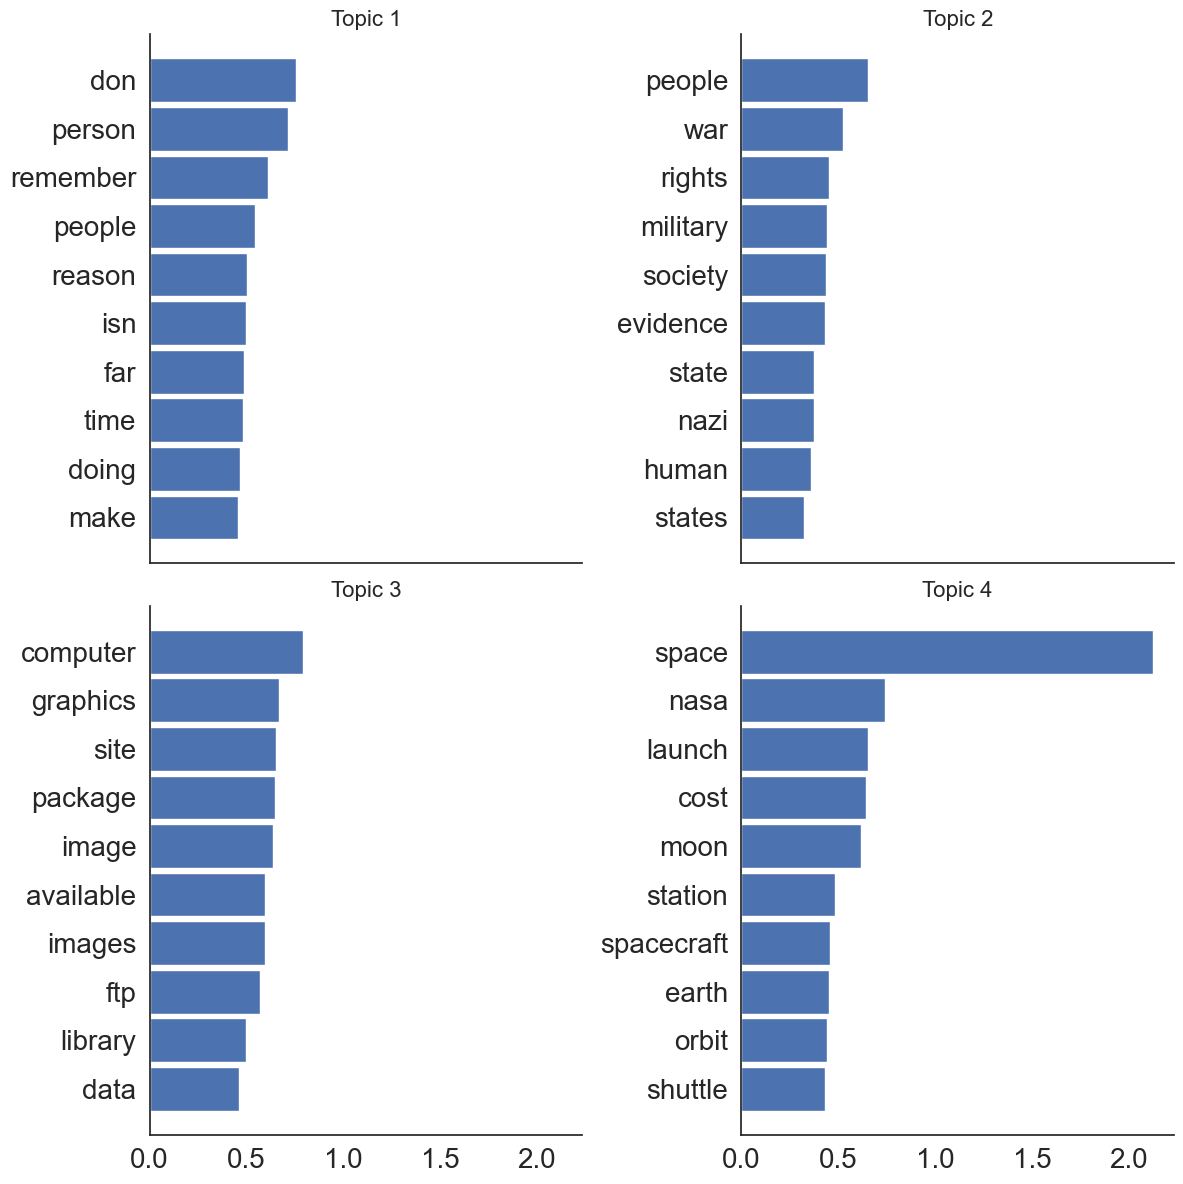

In [56]:
n_samples = 2000
n_features = 1000
n_components = 30
n_top_words = 10

# Load the 20 newsgroups dataset and vectorize it.
# We filter out stopwords, posts are stripped of common English words, words occurring in
# only one document or in at least 95% of the documents are removed.
categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]
data, _ = fetch_20newsgroups(
    shuffle=True,
    categories = categories,
    subset = 'train',
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
    
)

def plot_top_words(model, feature_names, n_top_words, title):
    params = {'legend.fontsize': 'xx-large',
              'figure.figsize': (12, 12),
             'axes.labelsize': 'xx-large',
             'axes.titlesize':'xx-large',
             'xtick.labelsize':'20',
             'ytick.labelsize':'20'}
    
    plt.rcParams.update(params)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
    axes = axes.flatten()
    plots = []

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        try:
            ax = axes[topic_idx]
            plots.append(ax)
            ax.barh(top_features, weights, height=0.9)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 16})
            ax.invert_yaxis()
            for i in "top right".split():
                ax.spines[i].set_visible(False)
        except: continue
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)    
    plt.tight_layout()


t0 = time()

data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)

t0 = time()
model = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    #alpha=0.1,
    l1_ratio=0.5,
).fit(tfidf)

print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out() # get_feature_names() in other versions of the library
plot_top_words(
    model,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

Figure 4.37: A plot of the four topics from the ABC news group data set with the top-10 words per topic in descending order ordered by weight.

<div class="alert alert-info" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"/>
        </div>
        <div class="col-xs-11">
            <strong>This example may take more than an hour to complete depending on your hardware. You might consider using <a href="https://colab.google/" target="_blank">Google Colab</a> in this instance.</strong>
        </div>
    </div>
</div>

   coherence
k           
2   0.279795
3   0.309897
4   0.339220
5   0.322540
6   0.332221


Text(0, 0.5, 'Topic coherence')

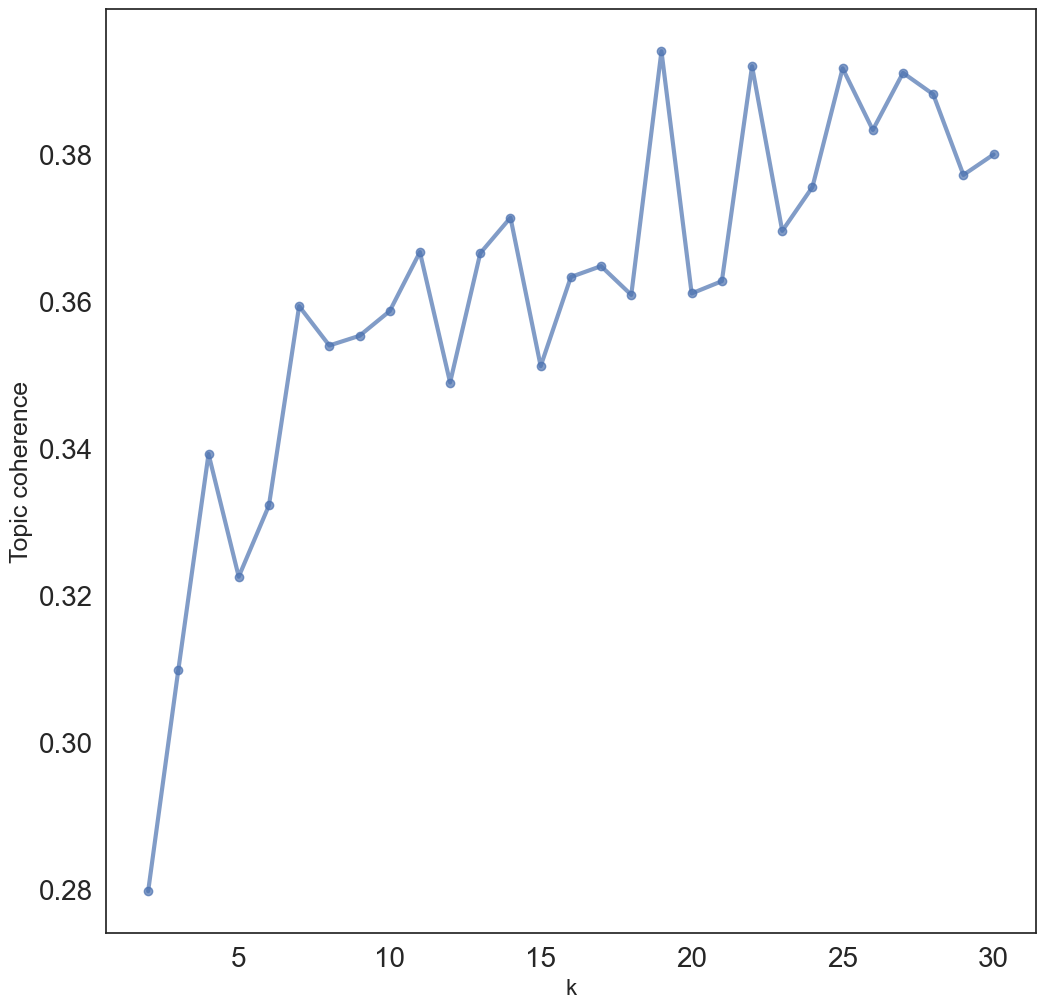

In [57]:
# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Evaluate topics
min_k = 2 
max_k = 31
evaluation_results = []

for k in range(min_k, max_k):
    model = GensimNmf(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        chunksize=10,
        passes=10,
        eval_every=10,
        minimum_probability=0,
        random_state=100,
        kappa=1,
    )
    # Set up coherence model
    co = CoherenceModel(
        model=model,
        corpus=id2word,
        coherence='c_v',
        texts = data_words
    ).get_coherence()
    
    evaluation_results.append([k, co])
    
# Save the results
df = pd.DataFrame(evaluation_results, columns=['k', 'coherence'])
df.set_index('k', inplace=True)

print(df.head())

# Plot the results
ax = df.plot(legend=False, marker="o", lw=3, alpha=0.7)
ax.set_xlabel("k", fontsize=16)
ax.set_ylabel("Topic coherence", fontsize=18)

Figure 4.38: A plot of the average topic coherence scores for the NMF model, with the number of topics ranging from k = 2 to k = 30.

### 4.4.5 DBSCAN

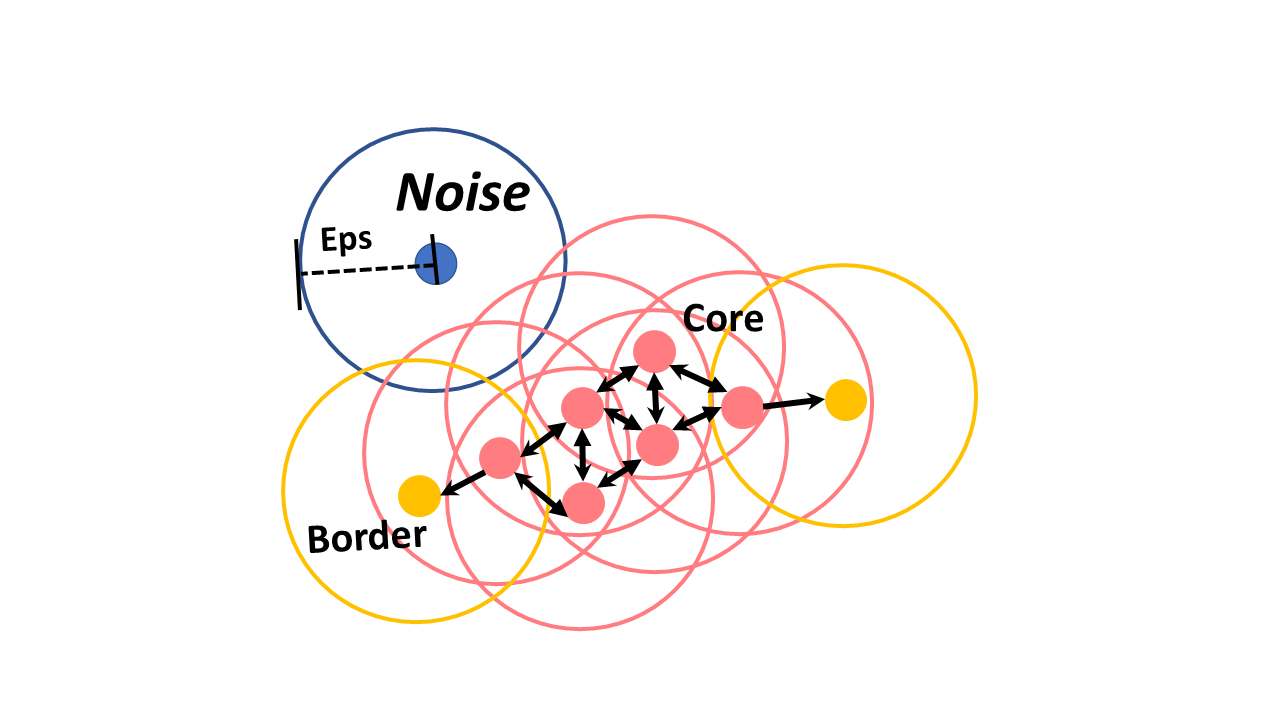

Figure 4.39: DBSCAN concepts.

**Example 4.13**: The swan data set is based on a study participating in the Arctic Animal Movement Archive (AAMA) analysing the flights of the Latvian Whooper Swans to different moulting sites in Russia throughout the year. The data set is composed of the latitudinal and longitudinal coordinates for four Whooper swans; see Table 4.23 for a sample from the data set.
DBSCAN was applied to the data set, resulting in a total of 22 clusters, with an overall silhouette coefficient score of 0.77, which suggests a good clustering. A plot of the clusters after removing noise points is shown in Figure 4.40

In [58]:
df = pd.read_csv("./data/Whooper swans in Latvia 2016.csv", low_memory=False);
print(df[['individual-local-identifier','timestamp','location-long','location-lat']].head())

   individual-local-identifier                timestamp  location-long  \
0  4307 9E04 (ECG3855 ACC4081)  2016-07-27 06:24:10.000      22.282067   
1  4307 9E04 (ECG3855 ACC4081)  2016-07-27 06:50:14.000      22.282617   
2  4307 9E04 (ECG3855 ACC4081)  2016-07-27 07:07:28.000      22.284017   
3  4307 9E04 (ECG3855 ACC4081)  2016-07-27 07:22:21.000      22.283800   
4  4307 9E04 (ECG3855 ACC4081)  2016-07-27 07:37:26.000      22.283950   

   location-lat  
0     57.062600  
1     57.062683  
2     57.062883  
3     57.063150  
4     57.062900  


Table 4.23: A sample from the Latvian Whooper Swan data set with the unique identifier for the swan and its geo-location at the specific time and date it was recorded at the moulting location.

1121 <class 'int'>
Estimated number of clusters: 22
Estimated number of noise points: 1121
Proportion of noisy points: 0.03419872479331279
Homogeneity: 0.176
Completeness: 0.999
V-measure: 0.299
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.125
Silhouette Coefficient: 0.771
[0 0 0 ... 0 0 0] 0 21
[0. 0. 0. ... 0. 0. 0.] 0.0 21.0
   location-long  location-lat  \
0      22.282067     57.062600   
1      22.282617     57.062683   
2      22.284017     57.062883   
3      22.283800     57.063150   
4      22.283950     57.062900   

                                              colour  
0  (0.6196078431372549, 0.00392156862745098, 0.25...  
1  (0.6196078431372549, 0.00392156862745098, 0.25...  
2  (0.6196078431372549, 0.00392156862745098, 0.25...  
3  (0.6196078431372549, 0.00392156862745098, 0.25...  
4  (0.6196078431372549, 0.00392156862745098, 0.25...  


Text(0, 0.5, 'Latitude')

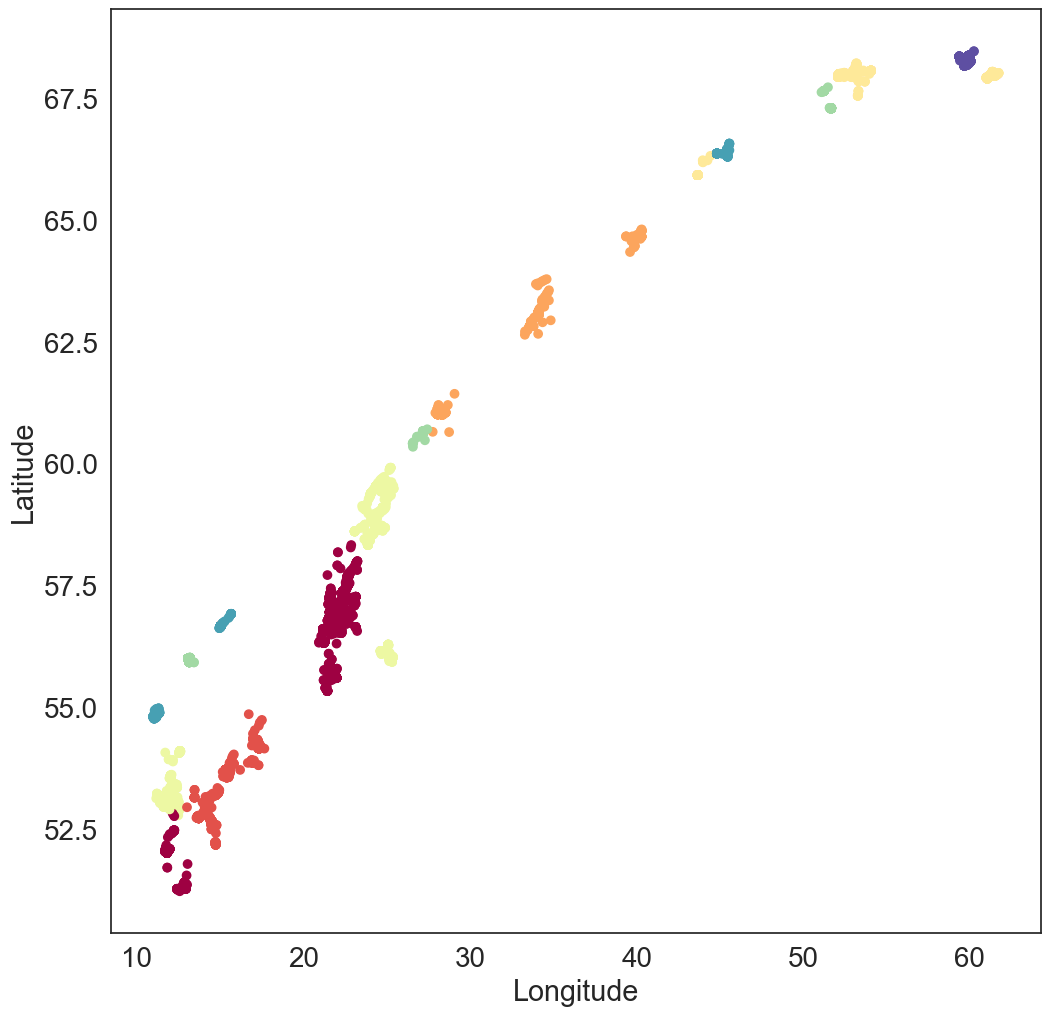

In [59]:
df = df[['location-long', 'location-lat']].dropna()
x = df['location-long']
y = df['location-lat']

# Initialise the model
model = DBSCAN(eps = .5, min_samples = 100).fit(df)

# The labels
labels = model.labels_
labels_true = y

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

# Number of clusters with respect to the labels, we ignore noise if it exists.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
noise = list(labels).count(-1)
print(noise, type(noise))

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % noise)
print ("Proportion of noisy points:", int(noise)/len(x))
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(df, labels))

plt.grid(False)

# Remove the noise
range_max = len(x)
x = np.array([x[i] for i in range(0, range_max) if labels[i] != -1])
y = np.array([y[i] for i in range(0, range_max) if labels[i] != -1])

# Extract levels and define colours and markers
labels = np.array([labels[i] for i in range(0, range_max) if labels[i] != -1])
colours = labels.astype(float)
markers = list(Line2D.markers.keys())
print(labels, min(labels), max(labels))
print(colours, min(colours), max(colours))
    
cm = plt.get_cmap('Spectral')

# Collect coordinates and assign colours
temp = []
NUM_COLORS = max(labels)
colours = []

for i in range(len(x)):
    col_idx = labels[i]
    rgb = cm(col_idx//3*3.0/NUM_COLORS)
    colours.append(rgb)
    temp.append((x[i], y[i], rgb))


mapdf = pd.DataFrame(temp, columns = ['location-long', 'location-lat', 'colour'])
print(mapdf.head())

# Generate scatter plot for training data
plt.scatter(x, y, c=colours, marker='o', cmap="Set1")

plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [60]:
def htmlcolor(r, g, b):
    def _chkarg(a):
        if isinstance(a, int): # clamp to range 0--255
            if a < 0:
                a = 0
            elif a > 255:
                a = 255
        elif isinstance(a, float): # clamp to range 0.0--1.0 and convert to integer 0--255
            if a < 0.0:
                a = 0
            elif a > 1.0:
                a = 255
            else:
                a = int(round(a*255))
        else:
            raise ValueError('Arguments must be integers or floats.')
        return a
    r = _chkarg(r)
    g = _chkarg(g)
    b = _chkarg(b)
    return '#{:02x}{:02x}{:02x}'.format(r,g,b)


mapdf = mapdf.sample(n=100,random_state=1)

long_list = mapdf['location-long'].to_list()
lat_list = mapdf['location-lat'].to_list()
colours_list = mapdf['colour'].to_list()
#print(long_list)
map = folium.Map(location=(lat_list[0], long_list[0]),zoom_start=3)
map.fit_bounds([[max(lat_list), min(lat_list)], [max(long_list), min(long_list)]])
x = df['location-long']
y = df['location-lat']

temp = {}
for l in range(len(long_list)):
    lat = lat_list[l]
    long = long_list[l]
    #colours[l] = list(colours[l])
    colour = colours_list[l]#htmlcolor(colours[l][0], colours[l][1], colours[l][2])
    
    colour = htmlcolor(colour[0], colour[1], colour[2])
    if type(lat) != float and type(long) != float: continue
    if temp.get(lat, None) != None and temp.get(lat, {}).get(long, None) != None: continue
    temp.setdefault(lat, {})[long] = True
    folium.Marker([lat, long], icon=folium.DivIcon(html='<div><svg><circle cx="2" cy="2" r="10" fill="'+colour+'" opacity="1"/></svg></div>') ).add_to(map)

map.save("./heat_map.html")
map

Figure 4.40: A plot of the clusters obtained from DBSCAN applied to the Whooper Swan data set, representing the moulting sites of the swans.

## 4.5 Semi-Supervised Methods

**Example 4.14**: The example is based on a modified version of the Breast Cancer data set. We reuse the breast cancer data set, shown in Figure 4.35, where a patient diagnosed with malignant breast cancer is assigned a class label 1 and a patient diagnosed with benign breast cancer is assigned a class label 0. The semi-supervised model is trained using the label propagation method. The resutling confusion matrix is shown in Figure 4.41 and the precision, recall and F1 for the semi-supervised model are shown in stylised form in Table 4.24.

In [61]:
rnd = np.random.RandomState(42)

# load the cancer dataset
cancer = load_breast_cancer()

df = pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns = np.append(cancer['feature_names'], ['target']))
print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

Table: A sample of the breast cancer dataset.

In [62]:
# Randomly unlabel some records in the dataset the unlabeled points will be labelled -1
random_unlabeled_points = rnd.rand(len(cancer.target)) < 0.6

labels = np.copy(cancer.target)

labels_orig = np.copy(cancer.target)
labels[random_unlabeled_points] = -1

X = cancer.data
tot_unlabled=labels[labels==-1]
print(f"Total Records in dataset is {len(X)} and unlabeled records is  {len(tot_unlabled)}")

# Initialise the model
model = LabelPropagation(kernel='knn', n_neighbors=3, gamma=30, max_iter=2000)

# fit model on training dataset
model.fit(X, labels)

# make predictions
test_y = labels_orig[random_unlabeled_points]
pred_y = model.predict(X[random_unlabeled_points])

print("Label propagation model: %d labeled & %d unlabeled points (%d total)" %
      (len(labels[labels!=-1]), len(tot_unlabled) , len(X)))

getEvaluationReport(test_y, pred_y)

Total Records in dataset is 569 and unlabeled records is  328
Label propagation model: 241 labeled & 328 unlabeled points (569 total)
              precision    recall  f1-score   support

           0       0.84      0.88      0.85       128
           1       0.92      0.89      0.90       200

    accuracy                           0.88       328
   macro avg       0.88      0.88      0.88       328
weighted avg       0.89      0.88      0.88       328

micro avg 0.8841463414634146 0.8841463414634146


Table 4.24: The precision, recall, and F1-score for a semi-supervised model trained to label data points as benign (0) or malignant (1).

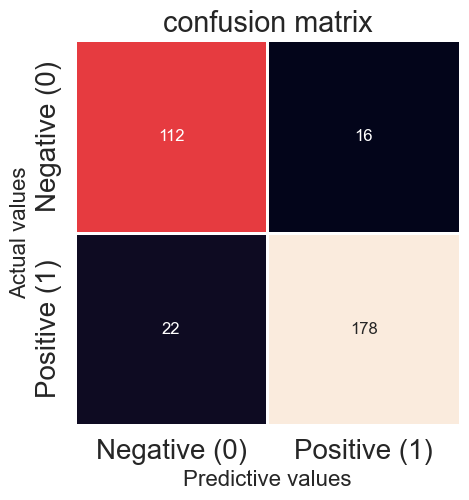

In [63]:
getConfusionMatrix(test_y, pred_y)

Figure 4.41: The confusion matrix for a semi-supervised model trained on the breast cancer data set.